# Installs & Imports

In [1]:
# Uninstall existing TensorFlow and Keras
!pip uninstall -y tensorflow keras

# Install TensorFlow
!pip install -q tensorflow==2.12

# Install Keras
!pip install -q keras==2.12

# Verify the installation
import tensorflow as tf
import keras
print(f"TensorFlow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Successfully uninstalled tensorflow-2.17.0
Found existing installation: keras 3.4.1
Uninstalling keras-3.4.1:
  Successfully uninstalled keras-3.4.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 80.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 74.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 94.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 100.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 MB 14.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of th

In [2]:
!pip install -q tfts optuna optuna-integration yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.9/96.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.1 MB/s eta 0:00:00


In [3]:
import os

# Set the environment variable before importing tfts
os.environ['TF_USE_LEGACY_KERAS'] = 'True'

# Import necessary libraries
import tfts
from tfts import AutoModel, AutoConfig, KerasTrainer

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import optuna
from optuna.integration import TFKerasPruningCallback

import warnings
warnings.filterwarnings('ignore')

import yfinance as yf

from typing import Tuple, Optional, List, Dict, Union, Any

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    print(f"Seed set to {seed}")

set_seed(42)

Seed set to 42


# Data Loading

In [5]:
def load_stock_data(ticker='AAPL', start_date='2010-01-01', end_date='2023-12-31') -> pd.DataFrame:
    """
    Download historical stock data using yfinance and return as a cleaned pandas DataFrame.

    Parameters:
    - ticker: str, stock ticker symbol.
    - start_date: str, start date in 'YYYY-MM-DD' format.
    - end_date: str, end date in 'YYYY-MM-DD' format.

    Returns:
    - df_clean: pandas DataFrame with 'Date' as index (formatted as 'dd-mm-yyyy') and 'value' column.
    """
    # Step 1: Download data
    print(f"Downloading data for {ticker} from {start_date} to {end_date}...")
    df = yf.download(ticker, start=start_date, end=end_date)

    if df.empty:
        raise ValueError(f"No data found for ticker {ticker}. Please check the ticker symbol.")

    print(f"Data downloaded successfully. Total records: {len(df)}")

    # Step 2: Select 'Close' and rename to 'value'
    print("\nSelecting the 'Close' column and renaming it to 'value'...")
    df = df[['Close']].copy()
    df.rename(columns={'Close': 'value'}, inplace=True)
    print("Columns after renaming:")
    print(df.columns)

    # Step 3: Handle MultiIndex columns if present
    if isinstance(df.columns, pd.MultiIndex):
        print("\nDetected MultiIndex columns. Flattening them...")
        # Flatten the MultiIndex by selecting the first level ('value') and renaming
        try:
            df = df.xs('value', axis=1, level='Price')
            print("Columns after selecting 'value' level:")
            print(df.columns)
        except KeyError:
            print("Key 'value' not found in the first level of MultiIndex columns.")
            raise

        # Rename the remaining column from ticker name to 'value'
        df.columns = ['value']
        print("Columns after renaming:")
        print(df.columns)
    else:
        print("No MultiIndex columns detected.")

    # Step 4: Convert index to datetime
    print("\nConverting index to datetime...")
    df.index = pd.to_datetime(df.index)
    print("Index after conversion:")
    print(df.index)

    # Step 5: Remove time component
    print("\nRemoving time component from the index...")
    df.index = df.index.normalize()
    print("Index after normalization:")
    print(df.index)

    # Step 6: Reformat dates to 'mm-dd-yyyy'
    print("\nReformatting dates to 'mm-dd-yyyy' format...")
    df.index = df.index.strftime('%m-%d-%Y')
    print("Index after reformatting:")
    print(df.index)

    # Step 7: Set index name
    df.index.name = 'Date'

    # Step 8: Final verification
    print("\nFinal DataFrame:")
    display(df.head())
    print("\nFinal DataFrame Info:")
    display(df.info())

    return df

In [6]:
# Execute data loading
df = load_stock_data(ticker='AAPL', start_date='2010-01-01', end_date='2023-12-31')

[*********************100%***********************]  1 of 1 completed

Data downloaded successfully. Total records: 3522

Selecting the 'Close' column and renaming it to 'value'...
Columns after renaming:
MultiIndex([('value', 'AAPL')],
           names=['Price', 'Ticker'])

Detected MultiIndex columns. Flattening them...
Columns after selecting 'value' level:
Index(['AAPL'], dtype='object', name='Ticker')
Columns after renaming:
Index(['value'], dtype='object')

Converting index to datetime...
Index after conversion:
DatetimeIndex(['2010-01-04 00:00:00+00:00', '2010-01-05 00:00:00+00:00',
               '2010-01-06 00:00:00+00:00', '2010-01-07 00:00:00+00:00',
               '2010-01-08 00:00:00+00:00', '2010-01-11 00:00:00+00:00',
               '2010-01-12 00:00:00+00:00', '2010-01-13 00:00:00+00:00',
               '2010-01-14 00:00:00+00:00', '2010-01-15 00:00:00+00:00',
               ...
               '2023-12-15 00:00:00+00:00', '2023-12-18 00:00:00+00:00',
               '2023-12-19 00:00:00+00:00', '2023-12-20 00:00:00+00:00',
               '2

,value
Date,
01-04-2010,7.643214
01-05-2010,7.656429
01-06-2010,7.534643
01-07-2010,7.520714
01-08-2010,7.570714



Final DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 3522 entries, 01-04-2010 to 12-29-2023
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   3522 non-null   float64
dtypes: float64(1)
memory usage: 55.0+ KB


None

# Data Exploration

In [7]:
def explore_data(df: pd.DataFrame):
    """
    Perform exploratory data analysis on the time series data.

    Parameters:
    - df: pandas DataFrame with the time series.
    """
    # Plot Time Series
    plt.figure(figsize=(14, 6))
    plt.plot(df.index, df['value'], label='Close Price')
    plt.title('AAPL Close Price Time Series')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.show()

    # Plot Distribution
    plt.figure(figsize=(8, 4))
    sns.histplot(df['value'], kde=True, bins=50)
    plt.title('Distribution of AAPL Close Prices')
    plt.xlabel('Price ($)')
    plt.ylabel('Frequency')
    plt.show()

    # Check Stationarity using Augmented Dickey-Fuller Test
    result = adfuller(df['value'])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    for key, value in result[4].items():
        print('Critical Value (%s): %.3f' % (key, value))
    if result[1] < 0.05:
        print("\nThe series is stationary.")
    else:
        print("\nThe series is non-stationary.")

    # Seasonal Decomposition
    decomposition = seasonal_decompose(df['value'], model='multiplicative', period=252)  # Approx. trading days in a year
    fig = decomposition.plot()
    fig.set_size_inches(14, 10)
    plt.show()

    # Plot Autocorrelation
    plt.figure(figsize=(12, 6))
    autocorrelation_plot(df['value'])
    plt.title('Autocorrelation Plot')
    plt.show()

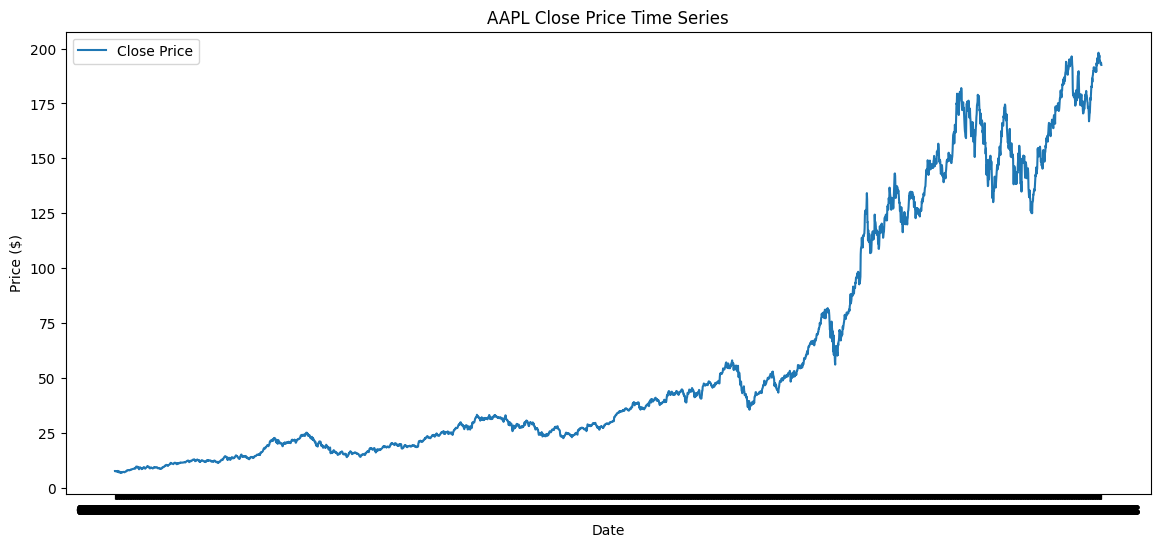

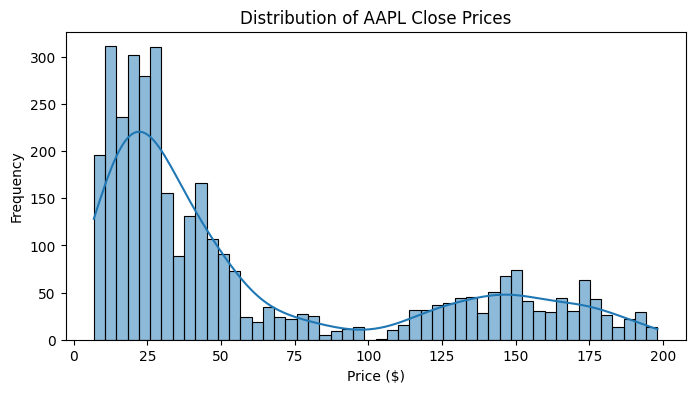

ADF Statistic: 0.819871
p-value: 0.991950
Critical Value (1%): -3.432
Critical Value (5%): -2.862
Critical Value (10%): -2.567

The series is non-stationary.


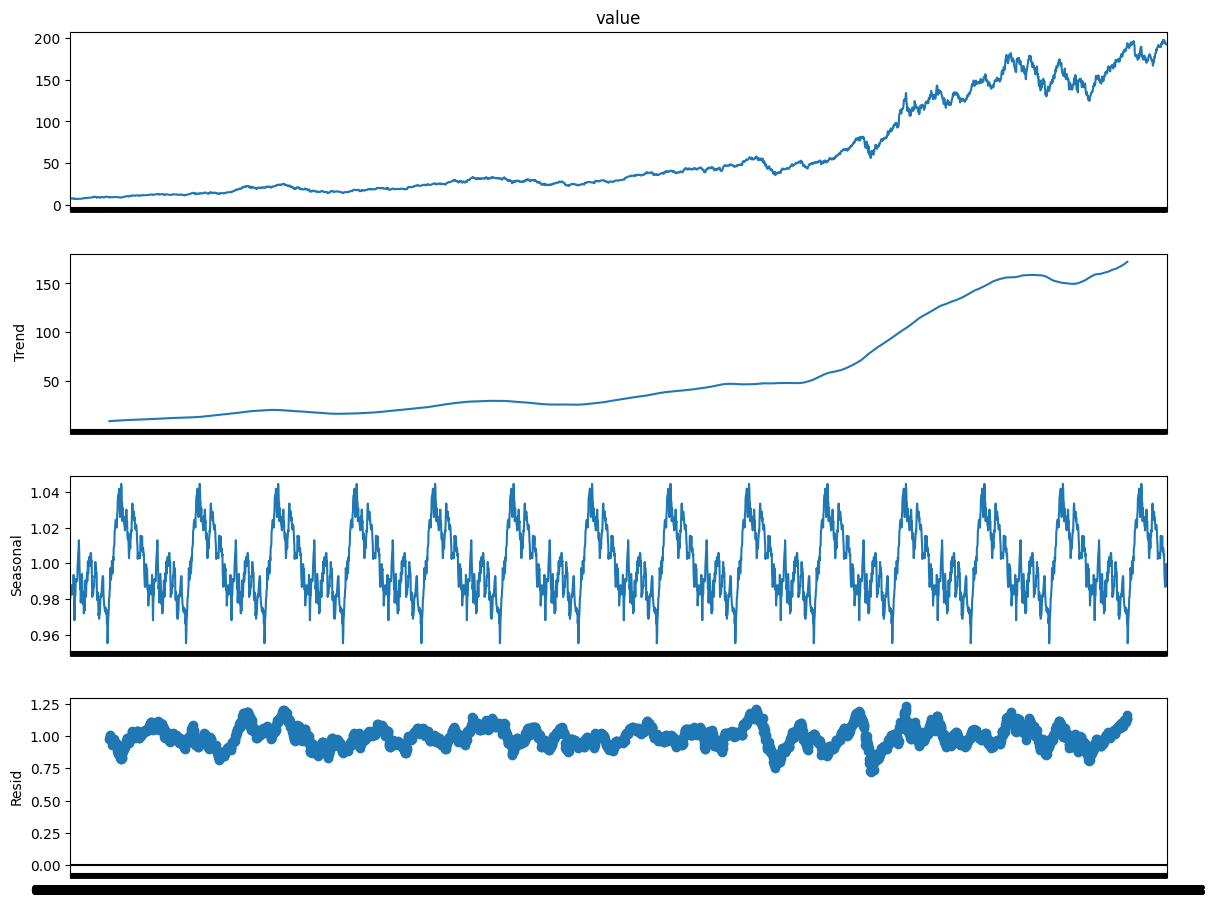

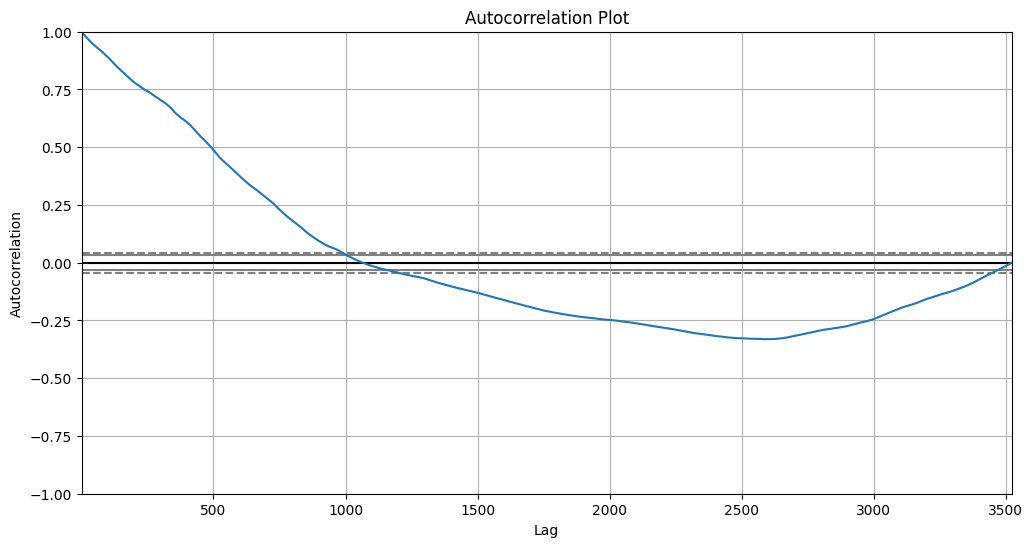

In [8]:
# Execute Data Exploration
explore_data(df)

# Data Preprocessing

In [9]:
def preprocess_data(
    df: pd.DataFrame,
    train_ratio: float = 0.7,
    validation_ratio: float = 0.15,
    test_ratio: float = 0.15,
    train_length: int = 60,
    predict_length: int = 30,
    scaler: Optional[StandardScaler] = None
) -> Tuple[
    Tuple[np.ndarray, np.ndarray],
    Tuple[np.ndarray, np.ndarray],
    Tuple[np.ndarray, np.ndarray],
    StandardScaler,
    float
]:
    """
    Preprocess the time series data: splitting, scaling, and creating train-validation-test samples.

    Parameters:
    - df: pandas DataFrame with the time series.
    - train_ratio: float, proportion of data to be used for training.
    - validation_ratio: float, proportion of data to be used for validation.
    - test_ratio: float, proportion of data to be used for testing.
    - train_length: int, number of past time steps to use for training.
    - predict_length: int, number of future time steps to predict.
    - scaler: scaler object, if None, StandardScaler is used.

    Returns:
    - (X_train, y_train): Training data.
    - (X_val, y_val): Validation data.
    - (X_test, y_test): Testing data.
    - scaler: fitted scaler object.
    - mae_naive: float, MAE of the naive forecast on training data.
    """
    if not np.isclose(train_ratio + validation_ratio + test_ratio, 1.0):
        raise ValueError("train_ratio, validation_ratio, and test_ratio must sum to 1.")

    values = df['value'].values.reshape(-1, 1)

    # Determine split indices
    total_length = len(values)
    train_end = int(total_length * train_ratio)
    val_end = train_end + int(total_length * validation_ratio)

    # Split the data
    train_values = values[:train_end]
    val_values = values[train_end:val_end]
    test_values = values[val_end:]

    # Initialize scaler and fit on training data
    if scaler is None:
        scaler = StandardScaler()
        scaler.fit(train_values)

    # Transform the data
    train_scaled = scaler.transform(train_values)
    val_scaled = scaler.transform(val_values)
    test_scaled = scaler.transform(test_values)

    def create_samples(data, train_length, predict_length):
        X, y = [], []
        for i in range(len(data) - train_length - predict_length + 1):
            X.append(data[i:i + train_length])
            y.append(data[i + train_length:i + train_length + predict_length])
        return np.array(X), np.array(y)

    # Create samples
    X_train, y_train = create_samples(train_scaled, train_length, predict_length)
    X_val, y_val = create_samples(val_scaled, train_length, predict_length)
    X_test, y_test = create_samples(test_scaled, train_length, predict_length)

    print(f"Training samples: {X_train.shape[0]}")
    print(f"Validation samples: {X_val.shape[0]}")
    print(f"Testing samples: {X_test.shape[0]}")

    # Compute MAE of naive forecast on training data
    # Naive forecast: predict the last value of the input sequence for all future steps
    y_train_naive = np.repeat(X_train[:, -1, :].reshape(-1, 1, 1), predict_length, axis=1)
    mae_naive = np.mean(np.abs(y_train - y_train_naive))
    print(f"MAE of Naive Forecast on Training Data: {mae_naive}")

    return (X_train, y_train), (X_val, y_val), (X_test, y_test), scaler, mae_naive

In [10]:
# Define parameters
train_length = 60     # Using 60 days of past data to predict
predict_length = 20   # Predicting the next 20 days
train_ratio = 0.8
validation_ratio = 0.10
test_ratio = 0.10

# Validate the ratios sum to 1
assert np.isclose(train_ratio + validation_ratio + test_ratio, 1.0), "Ratios must sum to 1."

# Execute Data Preprocessing
(train_data, train_labels), (val_data, val_labels), (test_data, test_labels), scaler, mae_naive = preprocess_data(
    df,
    train_ratio=train_ratio,
    validation_ratio=validation_ratio,
    test_ratio=test_ratio,
    train_length=train_length,
    predict_length=predict_length
)

Training samples: 2738
Validation samples: 273
Testing samples: 274
MAE of Naive Forecast on Training Data: 0.058954463649252976


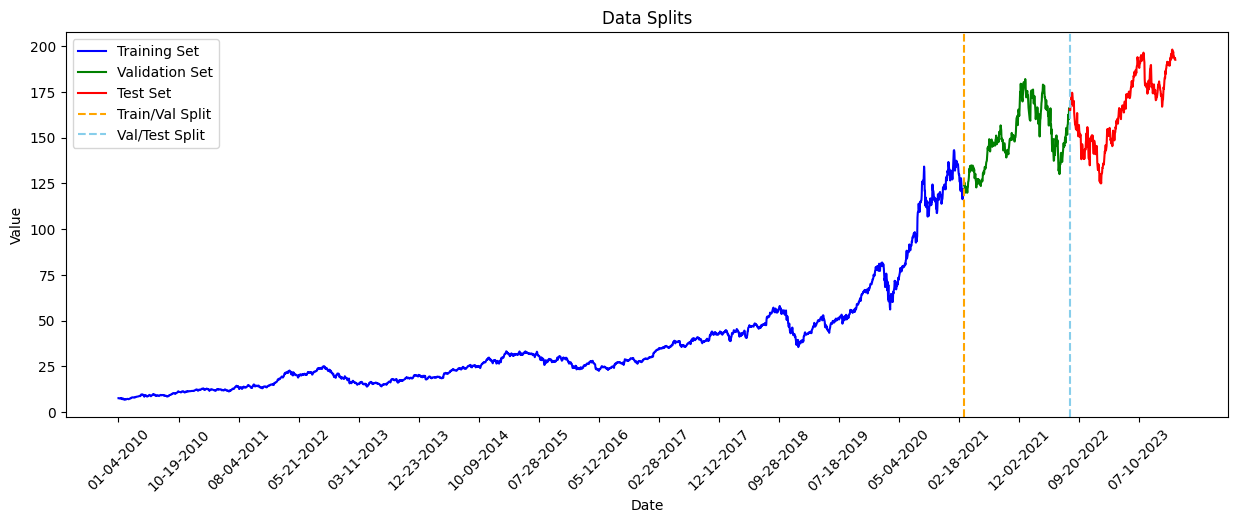

In [11]:
# Visualization of the splits
plt.figure(figsize=(15, 5))

# Calculate split points
train_end_idx = int(len(df) * train_ratio)
val_end_idx = train_end_idx + int(len(df) * validation_ratio)

# Plot the training set
plt.plot(df.index[:train_end_idx], df['value'][:train_end_idx], color='blue', label='Training Set')

# Plot the validation set
plt.plot(df.index[train_end_idx:val_end_idx], df['value'][train_end_idx:val_end_idx], color='green', label='Validation Set')

# Plot the test set
plt.plot(df.index[val_end_idx:], df['value'][val_end_idx:], color='red', label='Test Set')

# xtick labels only every 200 days
plt.xticks(df.index[::200], rotation=45)

plt.axvline(x=df.index[train_end_idx], color='orange', linestyle='--', label='Train/Val Split')
plt.axvline(x=df.index[val_end_idx], color='skyblue', linestyle='--', label='Val/Test Split')
plt.legend()
plt.title('Data Splits')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

# Model Training

## Seq2Seq

In [12]:
def train_seq2seq(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_val: np.ndarray,
    y_val: np.ndarray,
    predict_length: int = 20,
    epochs: int = 20,
    batch_size: int = 16,
    learning_rate: float = 1e-4
) -> KerasTrainer:
    """
    Define and train the Seq2Seq model using tfts.

    Parameters:
    - X_train, y_train: Training data.
    - X_val, y_val: Validation data.
    - predict_length: Number of future time steps to predict.
    - epochs: Number of training epochs.
    - batch_size: Batch size for training.
    - learning_rate: Learning rate for the optimizer.

    Returns:
    - Trained KerasTrainer object.
    """
    model_name_or_path = 'seq2seq'

    # Pass configuration parameters
    config = AutoConfig.for_model(
        model_name_or_path,
        hidden_size=64,
        num_layers=2,
        num_attention_heads=4
    )

    model = AutoModel.from_config(config, predict_length=predict_length)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss_fn = tf.keras.losses.MeanSquaredError()

    trainer = KerasTrainer(model, optimizer=optimizer, loss_fn=loss_fn)

    # Define EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    trainer.train(
        (X_train, y_train),
        valid_dataset=(X_val, y_val),
        n_epochs=epochs,
        batch_size=batch_size,
        early_stopping=early_stopping
    )
    print("Seq2Seq Model Trained.")
    return trainer

In [13]:
# Execute Seq2Seq Training
seq2seq_trainer = train_seq2seq(
    X_train=train_data,
    y_train=train_labels,
    X_val=val_data,
    y_val=val_labels,
    predict_length=predict_length,
    epochs=20,
    batch_size=16,
    learning_rate=1e-4
)

Epoch 1/20
172/172 - 55s - loss: 1.0531 - val_loss: 21.3069 - 55s/epoch - 322ms/step
Epoch 2/20
172/172 - 54s - loss: 1.0531 - val_loss: 21.3069 - 54s/epoch - 317ms/step
Epoch 3/20
172/172 - 54s - loss: 1.0531 - val_loss: 21.3069 - 54s/epoch - 312ms/step
Epoch 4/20
172/172 - 54s - loss: 1.0531 - val_loss: 21.3069 - 54s/epoch - 314ms/step
Epoch 5/20
172/172 - 56s - loss: 1.0531 - val_loss: 21.3069 - 56s/epoch - 325ms/step
Epoch 6/20
172/172 - 55s - loss: 1.0531 - val_loss: 21.3069 - 55s/epoch - 319ms/step
Seq2Seq Model Trained.


## AutoFormer

In [14]:
def train_autoformer(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_val: np.ndarray,
    y_val: np.ndarray,
    predict_length: int = 20,
    epochs: int = 20,
    batch_size: int = 16,
    learning_rate: float = 1e-4
) -> KerasTrainer:
    """
    Define and train the Autoformer model using tfts.

    Parameters:
    - X_train, y_train: Training data.
    - X_val, y_val: Validation data.
    - predict_length: Number of future time steps to predict.
    - epochs: Number of training epochs.
    - batch_size: Batch size for training.
    - learning_rate: Learning rate for the optimizer.

    Returns:
    - Trained KerasTrainer object.
    """
    model_name_or_path = 'autoformer'

    # Pass configuration parameters
    config = AutoConfig.for_model(
        model_name_or_path,
        hidden_size=64,
        num_layers=2,
        num_attention_heads=4,
        kernel_size=24,
        ffn_intermediate_size=256,
        hidden_dropout_prob=0.1,
        attention_probs_dropout_prob=0.1
    )

    model = AutoModel.from_config(config, predict_length=predict_length)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss_fn = tf.keras.losses.MeanSquaredError()

    trainer = KerasTrainer(model, optimizer=optimizer, loss_fn=loss_fn)

    # Define Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    trainer.train(
        (X_train, y_train),
        valid_dataset=(X_val, y_val),
        n_epochs=epochs,
        batch_size=batch_size,
        early_stopping=early_stopping
    )
    print("Autoformer Model Trained.")
    return trainer

In [15]:
# Execute Autoformer Training
autoformer_trainer = train_autoformer(
    X_train=train_data,
    y_train=train_labels,
    X_val=val_data,
    y_val=val_labels,
    predict_length=predict_length,
    epochs=20,
    batch_size=16,
    learning_rate=1e-4
)

Epoch 1/20
172/172 - 38s - loss: 0.9652 - val_loss: 19.3429 - 38s/epoch - 222ms/step
Epoch 2/20
172/172 - 38s - loss: 0.9648 - val_loss: 19.3429 - 38s/epoch - 220ms/step
Epoch 3/20
172/172 - 38s - loss: 0.9647 - val_loss: 19.3429 - 38s/epoch - 221ms/step
Epoch 4/20
172/172 - 38s - loss: 0.9643 - val_loss: 19.3429 - 38s/epoch - 221ms/step
Epoch 5/20
172/172 - 38s - loss: 0.9653 - val_loss: 19.3429 - 38s/epoch - 220ms/step
Epoch 6/20
172/172 - 38s - loss: 0.9649 - val_loss: 19.3429 - 38s/epoch - 220ms/step
Autoformer Model Trained.


## NBeats

In [16]:
import tfts.models.auto_config as auto_config

# Check current NBeats mapping
print("Current mapping for 'nbeats':", auto_config.CONFIG_MAPPING_NAMES.get("nbeats"))

Current mapping for 'nbeats': NBeatsConfig


In [17]:
# Update the mapping to the correct class name
auto_config.CONFIG_MAPPING_NAMES["nbeats"] = "NbeatsConfig"

print("Updated mapping for 'nbeats':", auto_config.CONFIG_MAPPING_NAMES.get("nbeats"))

Updated mapping for 'nbeats': NbeatsConfig


In [18]:
def train_nbeats(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_val: np.ndarray,
    y_val: np.ndarray,
    predict_length: int = 20,
    epochs: int = 20,
    batch_size: int = 16,
    learning_rate: float = 1e-4
) -> KerasTrainer:
    """
    Define and train the NBeats model using tfts.

    Parameters:
    - X_train, y_train: Training data.
    - X_val, y_val: Validation data.
    - predict_length: Number of future time steps to predict.
    - epochs: Number of training epochs.
    - batch_size: Batch size for training.
    - learning_rate: Learning rate for the optimizer.

    Returns:
    - Trained KerasTrainer object.
    """
    model_name_or_path = 'nbeats'

    # Pass configuration parameters
    config = AutoConfig.for_model(
        model_name_or_path,
        hidden_size=64,
        nb_blocks_per_stack=3,
        n_block_layers=4,
        thetas_dims=(4, 8)
    )

    model = AutoModel.from_config(config, predict_length=predict_length)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss_fn = tf.keras.losses.MeanSquaredError()

    trainer = KerasTrainer(model, optimizer=optimizer, loss_fn=loss_fn)

    # Define Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    trainer.train(
        (X_train, y_train),
        valid_dataset=(X_val, y_val),
        n_epochs=epochs,
        batch_size=batch_size,
        early_stopping=early_stopping
    )
    print("NBeats Model Trained.")
    return trainer

In [19]:
# Execute NBeats Training
nbeats_trainer = train_nbeats(
    X_train=train_data,
    y_train=train_labels,
    X_val=val_data,
    y_val=val_labels,
    predict_length=predict_length,
    epochs=20,
    batch_size=16,
    learning_rate=1e-4
)

Epoch 1/20
172/172 - 29s - loss: 16.8479 - val_loss: 289.5608 - 29s/epoch - 170ms/step
Epoch 2/20
172/172 - 29s - loss: 16.5859 - val_loss: 363.3430 - 29s/epoch - 169ms/step
Epoch 3/20
172/172 - 29s - loss: 20.4027 - val_loss: 382.9176 - 29s/epoch - 171ms/step
Epoch 4/20
172/172 - 30s - loss: 19.0530 - val_loss: 487.6700 - 30s/epoch - 172ms/step
Epoch 5/20
172/172 - 29s - loss: 18.3530 - val_loss: 200.1738 - 29s/epoch - 171ms/step
Epoch 6/20
172/172 - 29s - loss: 18.8927 - val_loss: 359.4702 - 29s/epoch - 171ms/step
Epoch 7/20
172/172 - 30s - loss: 17.3825 - val_loss: 400.7905 - 30s/epoch - 172ms/step
Epoch 8/20
172/172 - 29s - loss: 17.2231 - val_loss: 523.7485 - 29s/epoch - 171ms/step
Epoch 9/20
172/172 - 29s - loss: 19.6927 - val_loss: 416.3964 - 29s/epoch - 171ms/step
Epoch 10/20
172/172 - 29s - loss: 16.2341 - val_loss: 257.0320 - 29s/epoch - 170ms/step
NBeats Model Trained.


# Model Evaluation

In [20]:
def compute_mase(y_true: np.ndarray, y_pred: np.ndarray, mae_naive: float) -> float:
    """
    Compute Mean Absolute Scaled Error (MASE).

    Parameters:
    - y_true: Ground truth values.
    - y_pred: Predicted values.
    - mae_naive: MAE of the naive forecast.

    Returns:
    - MASE value.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred)) / mae_naive

In [21]:
from tensorflow.python.ops.numpy_ops import np_config

np_config.enable_numpy_behavior()

def evaluate_models(
    trainers: dict,
    X_test: np.ndarray,
    y_test: np.ndarray,
    scaler: StandardScaler,
    mae_naive: float
) -> Tuple[pd.DataFrame, dict]:
    """
    Evaluate trained models on the test set by flattening the predictions and true values.

    Parameters:
    - trainers: dict, keys are model names and values are KerasTrainer objects.
    - X_test, y_test: Test data.
    - scaler: StandardScaler object used for inverse transformation.
    - mae_naive: float, MAE of the naive forecast on training data.

    Returns:
    - metrics_df: DataFrame containing evaluation metrics for each model.
    - predictions: dict containing inverse-transformed predictions for each model.
    """
    metrics = {'Model': [], 'RMSE': [], 'MAE': [], 'MAPE': [], 'MASE': []}
    predictions = {}

    for model_name, trainer in trainers.items():
        pred = trainer.predict(X_test)  # Shape: (samples, predict_length, features)
        samples, predict_length, features = pred.shape

        # Flatten the arrays for inverse transformation and metric computation
        pred_flat = pred.reshape(samples * predict_length, features)
        y_test_flat = y_test.reshape(samples * predict_length, features)

        # Inverse transform
        pred_inv_flat = scaler.inverse_transform(pred_flat)
        y_test_inv_flat = scaler.inverse_transform(y_test_flat)

        # Compute Metrics
        rmse = np.sqrt(mean_squared_error(y_test_inv_flat, pred_inv_flat))
        mae = mean_absolute_error(y_test_inv_flat, pred_inv_flat)
        mape = mean_absolute_percentage_error(y_test_inv_flat, pred_inv_flat)
        mase = compute_mase(y_test_inv_flat, pred_inv_flat, mae_naive)

        metrics['Model'].append(model_name)
        metrics['RMSE'].append(rmse)
        metrics['MAE'].append(mae)
        metrics['MAPE'].append(mape)
        metrics['MASE'].append(mase)

        # Reshape predictions back to original shape for storage if needed
        pred_inv = pred_inv_flat.reshape(samples, predict_length, features)
        predictions[model_name] = pred_inv

        print(f"{model_name} - RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}, MASE: {mase:.4f}")

    print("\n")
    metrics_df = pd.DataFrame(metrics)
    return metrics_df, predictions

In [22]:
# Execute Model Evaluation
trainers = {
    'Seq2Seq': seq2seq_trainer,
    'AutoFormer': autoformer_trainer,
    'NBeats': nbeats_trainer
}
metrics_df, predictions = evaluate_models(
    trainers,
    X_test=test_data,
    y_test=test_labels,
    scaler=scaler,
    mae_naive=mae_naive
)
display(metrics_df)

Seq2Seq - RMSE: 139.8991, MAE: 138.4850, MAPE: 0.82, MASE: 2349.0164
AutoFormer - RMSE: 133.8265, MAE: 132.4661, MAPE: 0.79, MASE: 2246.9227
NBeats - RMSE: 530.8159, MAE: 441.6245, MAPE: 2.64, MASE: 7490.9422




,Model,RMSE,MAE,MAPE,MASE
0,Seq2Seq,139.899145,138.485003,0.821877,2349.016425
1,AutoFormer,133.826463,132.466123,0.785799,2246.922701
2,NBeats,530.815864,441.624479,2.638829,7490.942189


# Results Visualization

In [23]:
def plot_metrics(metrics_df: pd.DataFrame):
    """
    Plot bar charts for RMSE & MAE and MAPE & MASE separately.

    Parameters:
    - metrics_df: pandas DataFrame containing metrics.
    """
    # Plot RMSE and MAE together
    plt.figure(figsize=(12, 6))
    sns.barplot(data=metrics_df.melt(id_vars='Model', value_vars=['RMSE', 'MAE']),
                x='Model', y='value', hue='variable')
    plt.title('RMSE and MAE Comparison')
    plt.ylabel('Error')
    plt.show()

    # Plot MAPE separately
    plt.figure(figsize=(12, 6))
    sns.barplot(data=metrics_df, x='Model', y='MAPE', palette='viridis')
    plt.title('MAPE Comparison')
    plt.ylabel('MAPE')
    plt.show()

    # Plot MASE separately
    plt.figure(figsize=(12, 6))
    sns.barplot(data=metrics_df, x='Model', y='MASE', palette='magma')
    plt.title('MASE Comparison')
    plt.ylabel('MASE')
    plt.show()

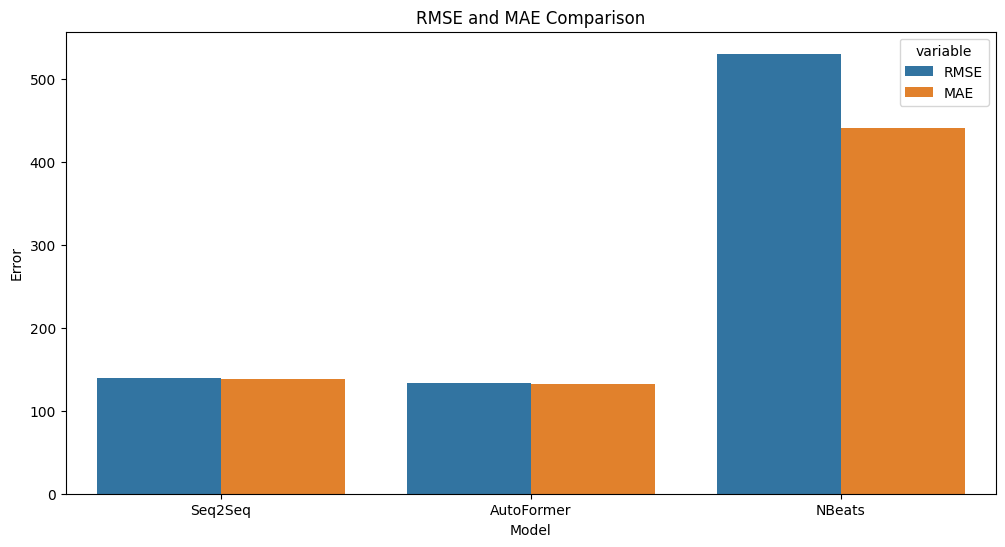

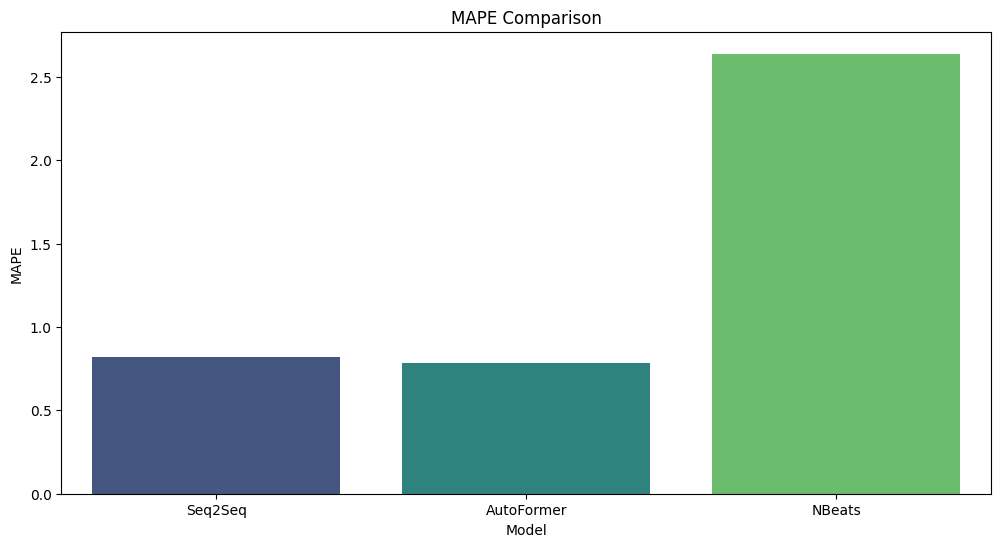

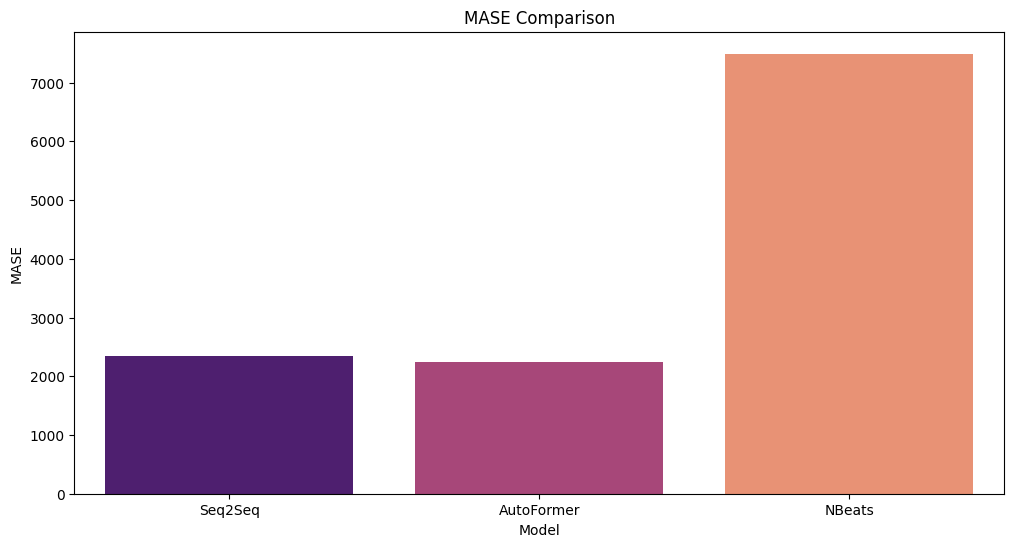

In [24]:
# Execute Metrics Visualization
plot_metrics(metrics_df)

In [25]:
def plot_predictions(
    predictions: Dict[str, np.ndarray],
    y_test: np.ndarray,
    scaler: StandardScaler,
    mae_naive: float,
    num_plots: int = 3,
    feature_idx: int = 0,
    exclude_models: Optional[List[str]] = None
):
    """
    Plot predicted vs. actual values for a few samples from the test set, with the option to exclude certain models.

    Parameters:
    - predictions: dict, keys are model names and values are predictions.
                   Each prediction should be a numpy array of shape (samples, predict_length, features).
    - y_test: numpy array, actual test targets. Shape: (samples, predict_length, features)
    - scaler: StandardScaler object used for inverse transformation.
    - mae_naive: float, MAE of the naive forecast on training data.
    - num_plots: int, number of samples to plot. Default is 3.
    - feature_idx: int, index of the feature to plot. Default is 0.
    - exclude_models: list of str, model names to exclude from plotting. Default is None.

    Returns:
    - None. Displays the plots.
    """
    # Validate input types
    if not isinstance(predictions, dict):
        raise ValueError("Predictions should be a dictionary with model names as keys and numpy arrays as values.")

    if exclude_models is not None:
        if not isinstance(exclude_models, list):
            raise ValueError("exclude_models should be a list of model names (strings).")

        # Check if models to exclude exist in predictions
        for model in exclude_models:
            if model not in predictions:
                print(f"Warning: Model '{model}' not found in predictions. It cannot be excluded.")

        # Filter out the excluded models
        predictions = {model: pred for model, pred in predictions.items() if model not in exclude_models}

    num_samples = y_test.shape[0]
    predict_length = y_test.shape[1]
    num_features = y_test.shape[2]

    # Validate feature index
    if feature_idx < 0 or feature_idx >= num_features:
        raise ValueError(f"Invalid feature_idx: {feature_idx}. It should be between 0 and {num_features - 1}.")

    # Ensure num_plots does not exceed the available samples
    num_plots = min(num_plots, num_samples)

    for i in range(num_plots):
        plt.figure(figsize=(14, 6))

        # Inverse transform actual values for the specified feature
        actual = y_test[i, :, feature_idx].reshape(-1, 1)
        actual_inv = scaler.inverse_transform(actual).flatten()

        # Plot actual values once
        plt.plot(range(predict_length), actual_inv, label='Actual', marker='o', linestyle='-', linewidth=2)

        # Plot predictions from remaining models
        for model_name, pred in predictions.items():
            # Inverse transform predictions for the specified feature
            predicted = pred[i, :, feature_idx].reshape(-1, 1)
            predicted_inv = scaler.inverse_transform(predicted).flatten()

            # Plot predictions
            plt.plot(range(predict_length), predicted_inv, label=f'Predicted by {model_name}', marker='x', linestyle='--')

        plt.title(f'Sample {i+1} - Feature {feature_idx + 1} - Actual vs. Predicted')
        plt.xlabel('Time Steps')
        plt.ylabel('Price ($)')
        plt.legend()
        plt.grid(True)
        plt.show()

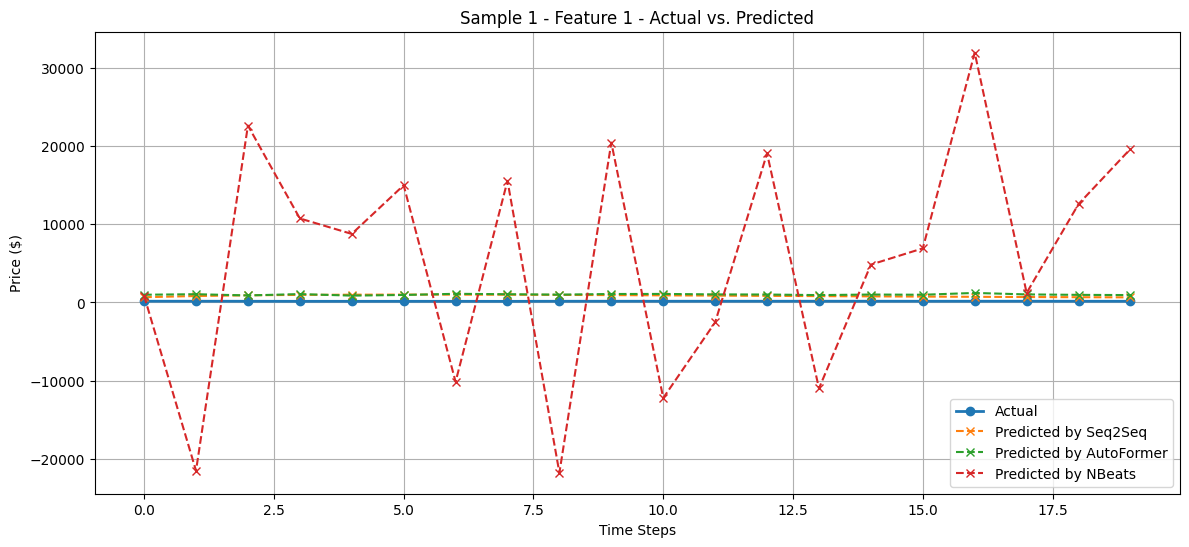

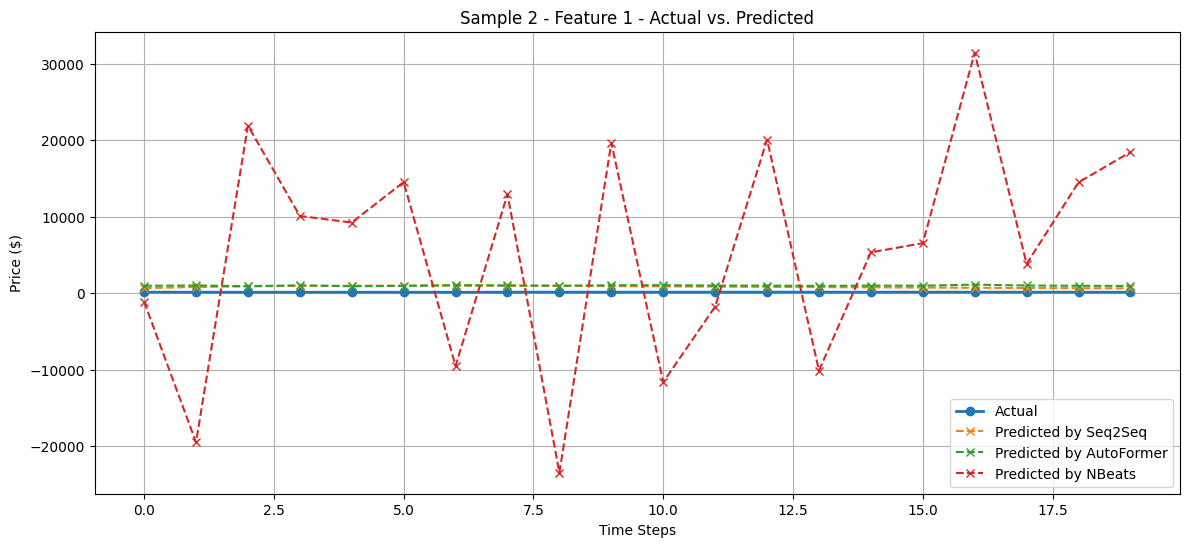

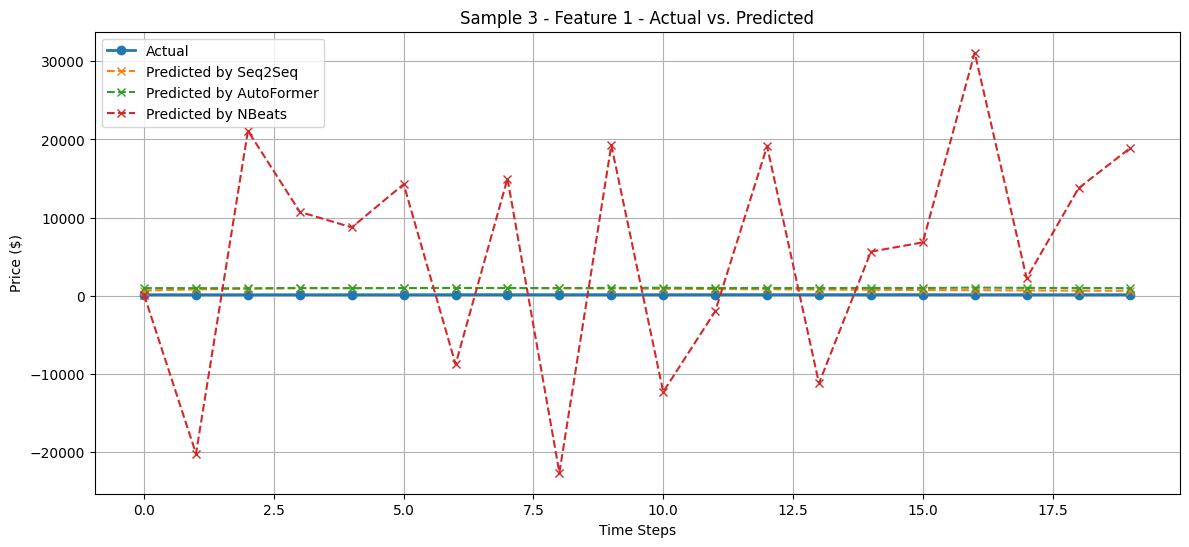

In [26]:
# Define the number of plots and feature index
num_plots = 3
feature_idx = 0

# Define models to exclude
exclude_models = []

# Execute Predictions Visualization
plot_predictions(
    predictions=predictions,
    y_test=test_labels,
    scaler=scaler,
    mae_naive=mae_naive,
    num_plots=num_plots,
    feature_idx=feature_idx,
    exclude_models=exclude_models
)

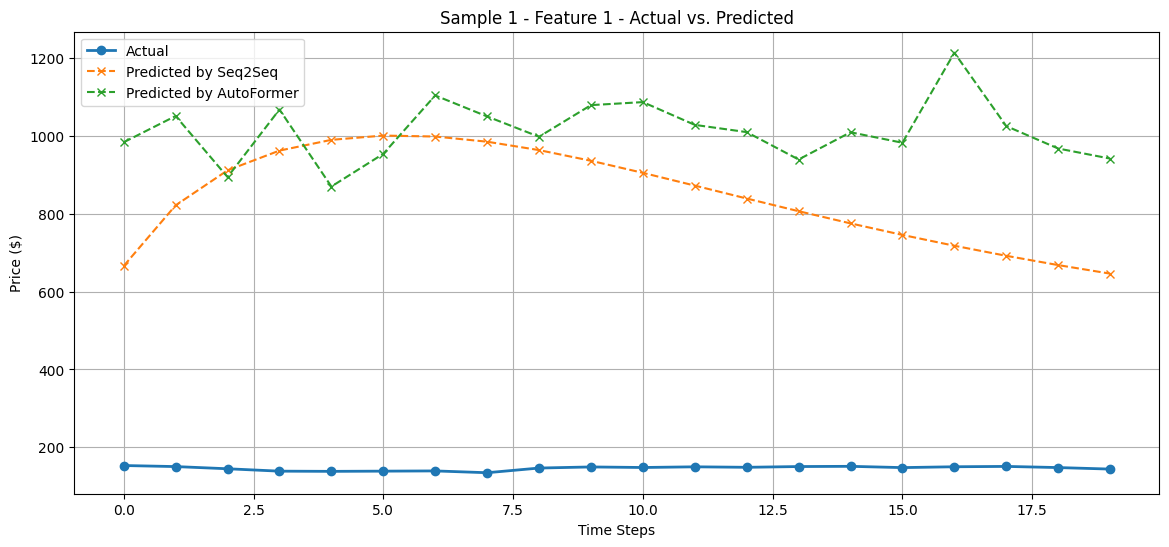

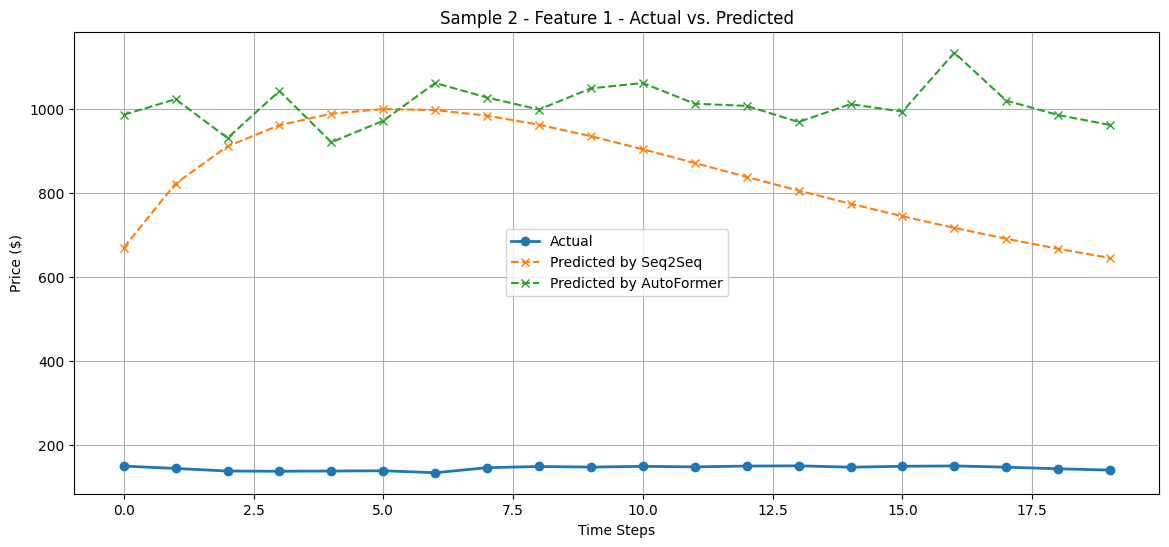

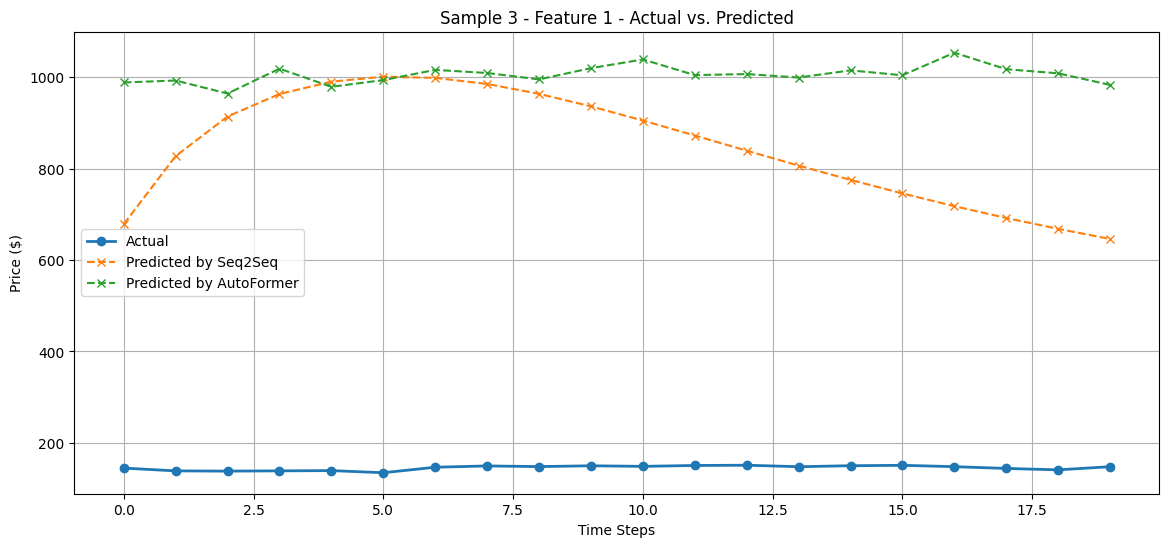

In [27]:
# Define the number of plots and feature index
num_plots = 3
feature_idx = 0

# Define models to exclude
exclude_models = ['NBeats']

# Execute Predictions Visualization
plot_predictions(
    predictions=predictions,
    y_test=test_labels,
    scaler=scaler,
    mae_naive=mae_naive,
    num_plots=num_plots,
    feature_idx=feature_idx,
    exclude_models=exclude_models
)

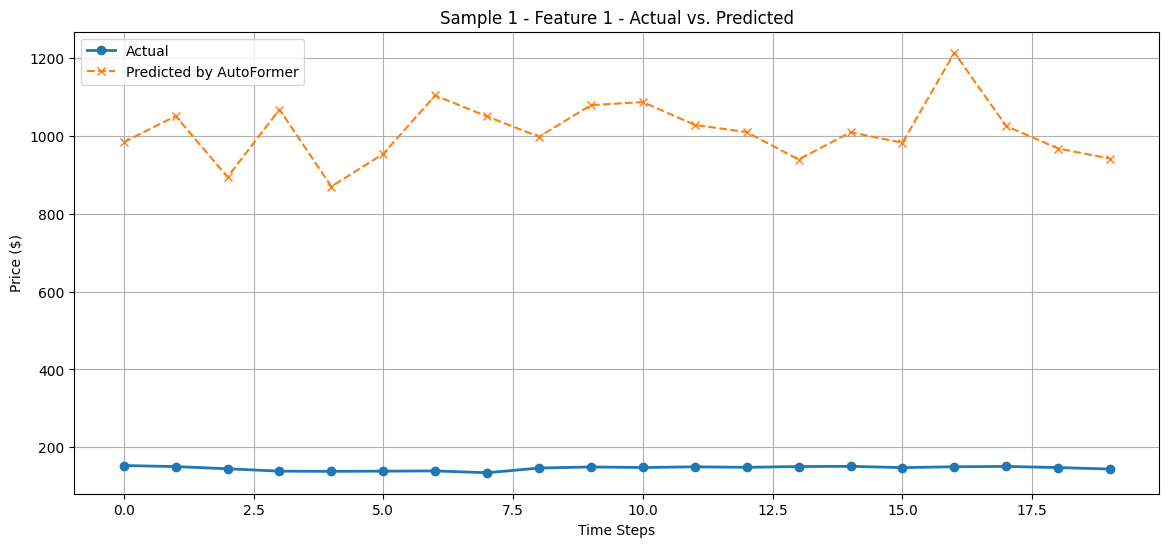

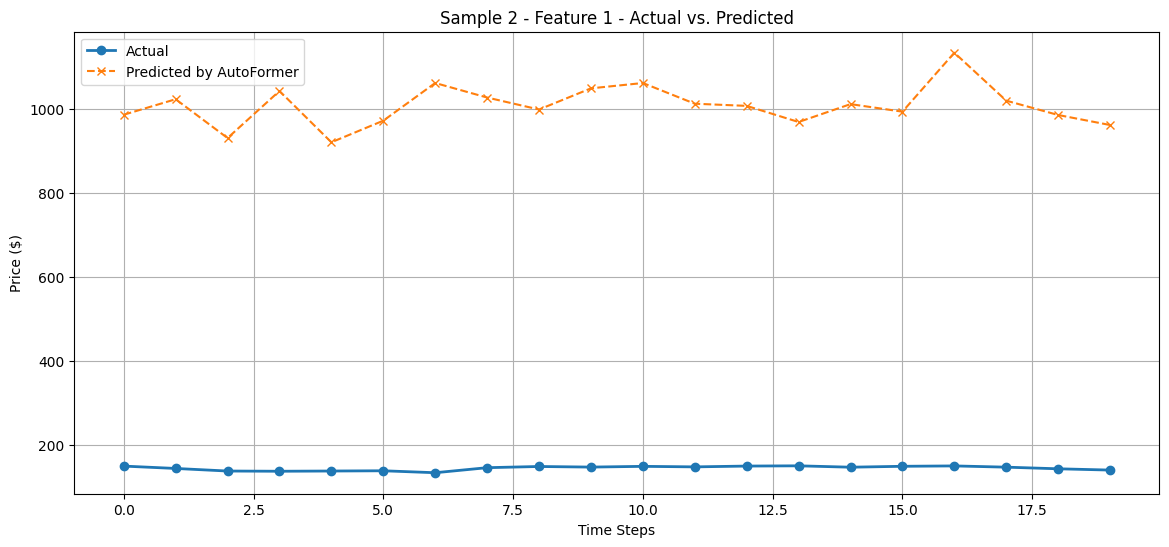

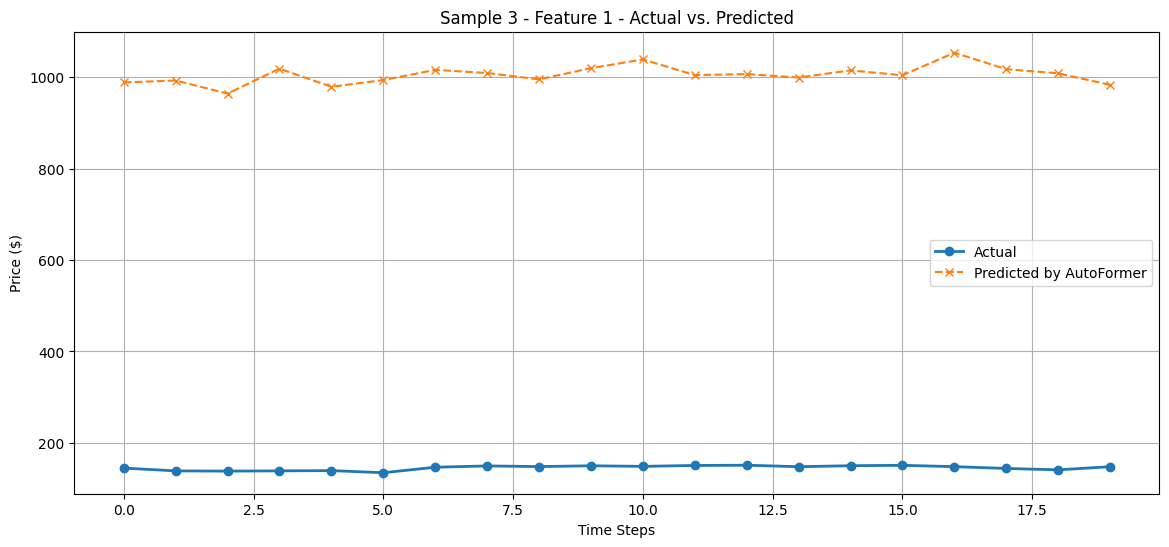

In [28]:
# Define the number of plots and feature index
num_plots = 3
feature_idx = 0

# Define models to exclude
exclude_models = ['NBeats', 'Seq2Seq']

# Execute Predictions Visualization
plot_predictions(
    predictions=predictions,
    y_test=test_labels,
    scaler=scaler,
    mae_naive=mae_naive,
    num_plots=num_plots,
    feature_idx=feature_idx,
    exclude_models=exclude_models
)

# Hyperparameter Tuning

## Seq2Seq

In [29]:
def objective_seq2seq(trial, X_train: np.ndarray, y_train: np.ndarray, scaler: StandardScaler, predict_length: int) -> float:
    """
    Objective function for Seq2Seq hyperparameter tuning using cross-validation.

    Parameters:
    - trial: Optuna trial object.
    - X_train, y_train: Training data.
    - scaler: StandardScaler object.
    - predict_length: Number of future time steps to predict.

    Returns:
    - Average MSE across cross-validation folds.
    """
    # Suggest hyperparameters
    hidden_size = trial.suggest_int('hidden_size', 32, 128)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    num_attention_heads = trial.suggest_int('num_attention_heads', 2, 8)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    epochs = 20

    # Configure the model
    config = AutoConfig.for_model('seq2seq')
    config.update({
        "hidden_size": hidden_size,
        "num_layers": num_layers,
        "num_attention_heads": num_attention_heads
    })
    model = AutoModel.from_config(config, predict_length=predict_length)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss_fn = tf.keras.losses.MeanSquaredError()

    # Initialize KerasTrainer
    trainer = KerasTrainer(model, optimizer=optimizer, loss_fn=loss_fn)

    # Time-aware cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    mse_scores = []

    for train_idx, val_idx in tscv.split(X_train):
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

        # Train the model
        trainer.train(
            (X_fold_train, y_fold_train),
            valid_dataset=(X_fold_val, y_fold_val),
            n_epochs=epochs,
            batch_size=16,
            early_stopping=EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        )

        # Predict
        pred = trainer.predict(X_fold_val)
        samples, predict_length, features = pred.shape

        # Flatten the arrays
        pred_flat = pred.reshape(samples * predict_length, features)
        y_val_flat = y_fold_val.reshape(samples * predict_length, features)

        # Inverse transform
        pred_inv_flat = scaler.inverse_transform(pred_flat)
        y_val_inv_flat = scaler.inverse_transform(y_val_flat)

        # Calculate MSE
        mse = mean_squared_error(y_val_inv_flat, pred_inv_flat)
        mse_scores.append(mse)

    average_mse = np.mean(mse_scores)
    return average_mse

In [30]:
def tune_seq2seq_optuna(X_train: np.ndarray, y_train: np.ndarray, scaler: StandardScaler, predict_length: int) -> dict:
    """
    Tune Seq2Seq hyperparameters using Optuna with cross-validation.

    Parameters:
    - X_train, y_train: Training data.
    - scaler: StandardScaler object.
    - predict_length: Number of future time steps to predict.

    Returns:
    - best_params: Dictionary of the best-found hyperparameters.
    """
    study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(lambda trial: objective_seq2seq(trial, X_train, y_train, scaler, predict_length), n_trials=10)

    print("Best trial for Seq2Seq:")
    trial = study.best_trial
    print(f"  Value (Average MSE): {trial.value:.4f}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")
    return trial.params

In [31]:
# Execute Seq2Seq Hyperparameter Tuning
best_params_seq2seq = tune_seq2seq_optuna(train_data, train_labels, scaler, predict_length)

[I 2024-11-03 16:52:57,808] A new study created in memory with name: no-name-598b1ea6-1d49-4955-9d3f-ee37daab710e


Epoch 1/20
29/29 - 15s - loss: 0.8032 - val_loss: 0.4236 - 15s/epoch - 508ms/step
Epoch 2/20
29/29 - 15s - loss: 0.8032 - val_loss: 0.4236 - 15s/epoch - 501ms/step
Epoch 3/20
29/29 - 15s - loss: 0.8032 - val_loss: 0.4236 - 15s/epoch - 505ms/step
Epoch 4/20
29/29 - 15s - loss: 0.8032 - val_loss: 0.4236 - 15s/epoch - 503ms/step
Epoch 5/20
29/29 - 15s - loss: 0.8032 - val_loss: 0.4236 - 15s/epoch - 502ms/step
Epoch 6/20
29/29 - 15s - loss: 0.8032 - val_loss: 0.4236 - 15s/epoch - 506ms/step
Epoch 1/20
58/58 - 25s - loss: 0.6138 - val_loss: 0.1796 - 25s/epoch - 426ms/step
Epoch 2/20
58/58 - 24s - loss: 0.6138 - val_loss: 0.1796 - 24s/epoch - 421ms/step
Epoch 3/20
58/58 - 25s - loss: 0.6138 - val_loss: 0.1796 - 25s/epoch - 423ms/step
Epoch 4/20
58/58 - 25s - loss: 0.6138 - val_loss: 0.1796 - 25s/epoch - 424ms/step
Epoch 5/20
58/58 - 25s - loss: 0.6138 - val_loss: 0.1796 - 25s/epoch - 423ms/step
Epoch 6/20
58/58 - 25s - loss: 0.6138 - val_loss: 0.1796 - 25s/epoch - 427ms/step
Epoch 1/20
86/86

[I 2024-11-03 17:10:04,792] Trial 0 finished with value: 731.7187524933189 and parameters: {'hidden_size': 68, 'num_layers': 3, 'num_attention_heads': 7, 'learning_rate': 0.0015751320499779737}. Best is trial 0 with value: 731.7187524933189.


Epoch 1/20
29/29 - 14s - loss: 5.4295 - val_loss: 4.3773 - 14s/epoch - 497ms/step
Epoch 2/20
29/29 - 14s - loss: 5.4295 - val_loss: 4.3773 - 14s/epoch - 498ms/step
Epoch 3/20
29/29 - 14s - loss: 5.4295 - val_loss: 4.3773 - 14s/epoch - 493ms/step
Epoch 4/20
29/29 - 14s - loss: 5.4295 - val_loss: 4.3773 - 14s/epoch - 492ms/step
Epoch 5/20
29/29 - 14s - loss: 5.4295 - val_loss: 4.3773 - 14s/epoch - 491ms/step
Epoch 6/20
29/29 - 14s - loss: 5.4295 - val_loss: 4.3773 - 14s/epoch - 494ms/step
Epoch 1/20
58/58 - 24s - loss: 4.9045 - val_loss: 3.4422 - 24s/epoch - 411ms/step
Epoch 2/20
58/58 - 24s - loss: 4.9045 - val_loss: 3.4422 - 24s/epoch - 406ms/step
Epoch 3/20
58/58 - 24s - loss: 4.9045 - val_loss: 3.4422 - 24s/epoch - 406ms/step
Epoch 4/20
58/58 - 24s - loss: 4.9045 - val_loss: 3.4422 - 24s/epoch - 408ms/step
Epoch 5/20
58/58 - 24s - loss: 4.9045 - val_loss: 3.4422 - 24s/epoch - 411ms/step
Epoch 6/20
58/58 - 24s - loss: 4.9045 - val_loss: 3.4422 - 24s/epoch - 411ms/step
Epoch 1/20
86/86

[I 2024-11-03 17:26:41,925] Trial 1 finished with value: 2107.710197212397 and parameters: {'hidden_size': 47, 'num_layers': 1, 'num_attention_heads': 2, 'learning_rate': 0.005399484409787433}. Best is trial 0 with value: 731.7187524933189.


Epoch 1/20
29/29 - 14s - loss: 2.7509 - val_loss: 2.0031 - 14s/epoch - 491ms/step
Epoch 2/20
29/29 - 15s - loss: 2.7509 - val_loss: 2.0031 - 15s/epoch - 506ms/step
Epoch 3/20
29/29 - 15s - loss: 2.7509 - val_loss: 2.0031 - 15s/epoch - 509ms/step
Epoch 4/20
29/29 - 15s - loss: 2.7509 - val_loss: 2.0031 - 15s/epoch - 503ms/step
Epoch 5/20
29/29 - 15s - loss: 2.7509 - val_loss: 2.0031 - 15s/epoch - 507ms/step
Epoch 6/20
29/29 - 14s - loss: 2.7509 - val_loss: 2.0031 - 14s/epoch - 500ms/step
Epoch 1/20
58/58 - 24s - loss: 2.3778 - val_loss: 1.3823 - 24s/epoch - 414ms/step
Epoch 2/20
58/58 - 24s - loss: 2.3778 - val_loss: 1.3823 - 24s/epoch - 417ms/step
Epoch 3/20
58/58 - 24s - loss: 2.3778 - val_loss: 1.3823 - 24s/epoch - 419ms/step
Epoch 4/20
58/58 - 24s - loss: 2.3778 - val_loss: 1.3823 - 24s/epoch - 421ms/step
Epoch 5/20
58/58 - 24s - loss: 2.3778 - val_loss: 1.3823 - 24s/epoch - 414ms/step
Epoch 6/20
58/58 - 24s - loss: 2.3778 - val_loss: 1.3823 - 24s/epoch - 416ms/step
Epoch 1/20
86/86

[I 2024-11-03 17:43:14,835] Trial 2 finished with value: 1053.9082785464975 and parameters: {'hidden_size': 90, 'num_layers': 3, 'num_attention_heads': 2, 'learning_rate': 0.008706020878304856}. Best is trial 0 with value: 731.7187524933189.


Epoch 1/20
29/29 - 14s - loss: 0.6950 - val_loss: 0.3511 - 14s/epoch - 474ms/step
Epoch 2/20
29/29 - 13s - loss: 0.6950 - val_loss: 0.3511 - 13s/epoch - 464ms/step
Epoch 3/20
29/29 - 14s - loss: 0.6950 - val_loss: 0.3511 - 14s/epoch - 484ms/step
Epoch 4/20
29/29 - 14s - loss: 0.6950 - val_loss: 0.3511 - 14s/epoch - 474ms/step
Epoch 5/20
29/29 - 14s - loss: 0.6950 - val_loss: 0.3511 - 14s/epoch - 473ms/step
Epoch 6/20
29/29 - 14s - loss: 0.6950 - val_loss: 0.3511 - 14s/epoch - 476ms/step
Epoch 1/20
58/58 - 23s - loss: 0.5234 - val_loss: 0.1440 - 23s/epoch - 394ms/step
Epoch 2/20
58/58 - 23s - loss: 0.5234 - val_loss: 0.1440 - 23s/epoch - 388ms/step
Epoch 3/20
58/58 - 23s - loss: 0.5234 - val_loss: 0.1440 - 23s/epoch - 397ms/step
Epoch 4/20
58/58 - 23s - loss: 0.5234 - val_loss: 0.1440 - 23s/epoch - 390ms/step
Epoch 5/20
58/58 - 23s - loss: 0.5234 - val_loss: 0.1440 - 23s/epoch - 396ms/step
Epoch 6/20
58/58 - 23s - loss: 0.5234 - val_loss: 0.1440 - 23s/epoch - 400ms/step
Epoch 1/20
86/86

[I 2024-11-03 17:59:34,427] Trial 3 finished with value: 759.0692403359122 and parameters: {'hidden_size': 112, 'num_layers': 1, 'num_attention_heads': 3, 'learning_rate': 0.00023270677083837802}. Best is trial 0 with value: 731.7187524933189.


Epoch 1/20
29/29 - 14s - loss: 0.5667 - val_loss: 0.2584 - 14s/epoch - 484ms/step
Epoch 2/20
29/29 - 14s - loss: 0.5667 - val_loss: 0.2584 - 14s/epoch - 484ms/step
Epoch 3/20
29/29 - 14s - loss: 0.5667 - val_loss: 0.2584 - 14s/epoch - 484ms/step
Epoch 4/20
29/29 - 14s - loss: 0.5667 - val_loss: 0.2584 - 14s/epoch - 488ms/step
Epoch 5/20
29/29 - 14s - loss: 0.5667 - val_loss: 0.2584 - 14s/epoch - 489ms/step
Epoch 6/20
29/29 - 15s - loss: 0.5667 - val_loss: 0.2584 - 15s/epoch - 501ms/step
Epoch 1/20
58/58 - 24s - loss: 0.4129 - val_loss: 0.0897 - 24s/epoch - 412ms/step
Epoch 2/20
58/58 - 24s - loss: 0.4129 - val_loss: 0.0897 - 24s/epoch - 410ms/step
Epoch 3/20
58/58 - 24s - loss: 0.4129 - val_loss: 0.0897 - 24s/epoch - 407ms/step
Epoch 4/20
58/58 - 24s - loss: 0.4129 - val_loss: 0.0897 - 24s/epoch - 410ms/step
Epoch 5/20
58/58 - 24s - loss: 0.4129 - val_loss: 0.0897 - 24s/epoch - 413ms/step
Epoch 6/20
58/58 - 24s - loss: 0.4129 - val_loss: 0.0897 - 24s/epoch - 408ms/step
Epoch 1/20
86/86

[I 2024-11-03 18:15:45,635] Trial 4 finished with value: 797.6575061591882 and parameters: {'hidden_size': 61, 'num_layers': 2, 'num_attention_heads': 5, 'learning_rate': 0.0003823475224675188}. Best is trial 0 with value: 731.7187524933189.


Epoch 1/20
29/29 - 14s - loss: 0.5367 - val_loss: 0.2410 - 14s/epoch - 469ms/step
Epoch 2/20
29/29 - 13s - loss: 0.5367 - val_loss: 0.2410 - 13s/epoch - 463ms/step
Epoch 3/20
29/29 - 14s - loss: 0.5367 - val_loss: 0.2410 - 14s/epoch - 472ms/step
Epoch 4/20
29/29 - 14s - loss: 0.5367 - val_loss: 0.2410 - 14s/epoch - 466ms/step
Epoch 5/20
29/29 - 14s - loss: 0.5367 - val_loss: 0.2410 - 14s/epoch - 467ms/step
Epoch 6/20
29/29 - 14s - loss: 0.5367 - val_loss: 0.2410 - 14s/epoch - 471ms/step
Epoch 1/20
58/58 - 22s - loss: 0.3892 - val_loss: 0.0855 - 22s/epoch - 388ms/step
Epoch 2/20
58/58 - 22s - loss: 0.3892 - val_loss: 0.0855 - 22s/epoch - 388ms/step
Epoch 3/20
58/58 - 23s - loss: 0.3892 - val_loss: 0.0855 - 23s/epoch - 389ms/step
Epoch 4/20
58/58 - 23s - loss: 0.3892 - val_loss: 0.0855 - 23s/epoch - 391ms/step
Epoch 5/20
58/58 - 23s - loss: 0.3892 - val_loss: 0.0855 - 23s/epoch - 399ms/step
Epoch 6/20
58/58 - 23s - loss: 0.3892 - val_loss: 0.0855 - 23s/epoch - 399ms/step
Epoch 1/20
86/86

[I 2024-11-03 18:32:01,408] Trial 5 finished with value: 807.541777392345 and parameters: {'hidden_size': 91, 'num_layers': 1, 'num_attention_heads': 4, 'learning_rate': 0.0005404103854647331}. Best is trial 0 with value: 731.7187524933189.


Epoch 1/20
29/29 - 14s - loss: 4.3287 - val_loss: 3.3803 - 14s/epoch - 488ms/step
Epoch 2/20
29/29 - 14s - loss: 4.3287 - val_loss: 3.3803 - 14s/epoch - 487ms/step
Epoch 3/20
29/29 - 14s - loss: 4.3287 - val_loss: 3.3803 - 14s/epoch - 489ms/step
Epoch 4/20
29/29 - 14s - loss: 4.3287 - val_loss: 3.3803 - 14s/epoch - 495ms/step
Epoch 5/20
29/29 - 14s - loss: 4.3287 - val_loss: 3.3803 - 14s/epoch - 487ms/step
Epoch 6/20
29/29 - 14s - loss: 4.3287 - val_loss: 3.3803 - 14s/epoch - 490ms/step
Epoch 1/20
58/58 - 24s - loss: 3.8556 - val_loss: 2.5564 - 24s/epoch - 406ms/step
Epoch 2/20
58/58 - 23s - loss: 3.8556 - val_loss: 2.5564 - 23s/epoch - 405ms/step
Epoch 3/20
58/58 - 23s - loss: 3.8556 - val_loss: 2.5564 - 23s/epoch - 396ms/step
Epoch 4/20
58/58 - 23s - loss: 3.8556 - val_loss: 2.5564 - 23s/epoch - 396ms/step
Epoch 5/20
58/58 - 23s - loss: 3.8556 - val_loss: 2.5564 - 23s/epoch - 399ms/step
Epoch 6/20
58/58 - 23s - loss: 3.8556 - val_loss: 2.5564 - 23s/epoch - 396ms/step
Epoch 1/20
86/86

[I 2024-11-03 18:48:18,360] Trial 6 finished with value: 1645.2186160042183 and parameters: {'hidden_size': 76, 'num_layers': 3, 'num_attention_heads': 3, 'learning_rate': 0.0010677482709481358}. Best is trial 0 with value: 731.7187524933189.


Epoch 1/20
29/29 - 14s - loss: 1.1112 - val_loss: 0.6517 - 14s/epoch - 483ms/step
Epoch 2/20
29/29 - 14s - loss: 1.1112 - val_loss: 0.6517 - 14s/epoch - 485ms/step
Epoch 3/20
29/29 - 14s - loss: 1.1112 - val_loss: 0.6517 - 14s/epoch - 482ms/step
Epoch 4/20
29/29 - 14s - loss: 1.1112 - val_loss: 0.6517 - 14s/epoch - 483ms/step
Epoch 5/20
29/29 - 14s - loss: 1.1112 - val_loss: 0.6517 - 14s/epoch - 480ms/step
Epoch 6/20
29/29 - 14s - loss: 1.1112 - val_loss: 0.6517 - 14s/epoch - 483ms/step
Epoch 1/20
58/58 - 23s - loss: 0.8820 - val_loss: 0.3275 - 23s/epoch - 398ms/step
Epoch 2/20
58/58 - 24s - loss: 0.8820 - val_loss: 0.3275 - 24s/epoch - 409ms/step
Epoch 3/20
58/58 - 24s - loss: 0.8820 - val_loss: 0.3275 - 24s/epoch - 407ms/step
Epoch 4/20
58/58 - 24s - loss: 0.8820 - val_loss: 0.3275 - 24s/epoch - 408ms/step
Epoch 5/20
58/58 - 23s - loss: 0.8820 - val_loss: 0.3275 - 23s/epoch - 404ms/step
Epoch 6/20
58/58 - 24s - loss: 0.8820 - val_loss: 0.3275 - 24s/epoch - 408ms/step
Epoch 1/20
86/86

[I 2024-11-03 19:04:36,773] Trial 7 finished with value: 725.8512423574805 and parameters: {'hidden_size': 89, 'num_layers': 1, 'num_attention_heads': 6, 'learning_rate': 0.00021930485556643703}. Best is trial 7 with value: 725.8512423574805.


Epoch 1/20
29/29 - 15s - loss: 0.8022 - val_loss: 0.4194 - 15s/epoch - 507ms/step
Epoch 2/20
29/29 - 14s - loss: 0.8022 - val_loss: 0.4194 - 14s/epoch - 499ms/step
Epoch 3/20
29/29 - 14s - loss: 0.8022 - val_loss: 0.4194 - 14s/epoch - 490ms/step
Epoch 4/20
29/29 - 14s - loss: 0.8022 - val_loss: 0.4194 - 14s/epoch - 490ms/step
Epoch 5/20
29/29 - 14s - loss: 0.8022 - val_loss: 0.4194 - 14s/epoch - 492ms/step
Epoch 6/20
29/29 - 14s - loss: 0.8022 - val_loss: 0.4194 - 14s/epoch - 490ms/step
Epoch 1/20
58/58 - 24s - loss: 0.6112 - val_loss: 0.1758 - 24s/epoch - 405ms/step
Epoch 2/20
58/58 - 23s - loss: 0.6112 - val_loss: 0.1758 - 23s/epoch - 404ms/step
Epoch 3/20
58/58 - 24s - loss: 0.6112 - val_loss: 0.1758 - 24s/epoch - 410ms/step
Epoch 4/20
58/58 - 24s - loss: 0.6112 - val_loss: 0.1758 - 24s/epoch - 407ms/step
Epoch 5/20
58/58 - 23s - loss: 0.6112 - val_loss: 0.1758 - 23s/epoch - 404ms/step
Epoch 6/20
58/58 - 23s - loss: 0.6112 - val_loss: 0.1758 - 23s/epoch - 404ms/step
Epoch 1/20
86/86

[I 2024-11-03 19:20:56,899] Trial 8 finished with value: 748.9727454763749 and parameters: {'hidden_size': 38, 'num_layers': 3, 'num_attention_heads': 8, 'learning_rate': 0.004138040112561018}. Best is trial 7 with value: 725.8512423574805.


Epoch 1/20
29/29 - 14s - loss: 0.2081 - val_loss: 0.2838 - 14s/epoch - 497ms/step
Epoch 2/20
29/29 - 14s - loss: 0.2081 - val_loss: 0.2838 - 14s/epoch - 499ms/step
Epoch 3/20
29/29 - 14s - loss: 0.2081 - val_loss: 0.2838 - 14s/epoch - 494ms/step
Epoch 4/20
29/29 - 14s - loss: 0.2081 - val_loss: 0.2838 - 14s/epoch - 490ms/step
Epoch 5/20
29/29 - 14s - loss: 0.2081 - val_loss: 0.2838 - 14s/epoch - 489ms/step
Epoch 6/20
29/29 - 14s - loss: 0.2081 - val_loss: 0.2838 - 14s/epoch - 489ms/step
Epoch 1/20
58/58 - 24s - loss: 0.2459 - val_loss: 0.5135 - 24s/epoch - 408ms/step
Epoch 2/20
58/58 - 24s - loss: 0.2459 - val_loss: 0.5135 - 24s/epoch - 407ms/step
Epoch 3/20
58/58 - 24s - loss: 0.2459 - val_loss: 0.5135 - 24s/epoch - 408ms/step
Epoch 4/20
58/58 - 24s - loss: 0.2459 - val_loss: 0.5135 - 24s/epoch - 407ms/step
Epoch 5/20
58/58 - 24s - loss: 0.2459 - val_loss: 0.5135 - 24s/epoch - 409ms/step
Epoch 6/20
58/58 - 24s - loss: 0.2459 - val_loss: 0.5135 - 24s/epoch - 407ms/step
Epoch 1/20
86/86

[I 2024-11-03 19:37:15,683] Trial 9 finished with value: 1753.8266386319879 and parameters: {'hidden_size': 61, 'num_layers': 1, 'num_attention_heads': 6, 'learning_rate': 0.0007591104805282694}. Best is trial 7 with value: 725.8512423574805.


Best trial for Seq2Seq:
  Value (Average MSE): 725.8512
  Params: 
    hidden_size: 89
    num_layers: 1
    num_attention_heads: 6
    learning_rate: 0.00021930485556643703


## AutoFormer

In [32]:
def objective_autoformer(trial, X_train: np.ndarray, y_train: np.ndarray, scaler: StandardScaler, predict_length: int) -> float:
    """
    Objective function for Autoformer hyperparameter tuning using cross-validation.

    Parameters:
    - trial: Optuna trial object.
    - X_train, y_train: Training data.
    - scaler: StandardScaler object.
    - predict_length: Number of future time steps to predict.

    Returns:
    - Average MSE across cross-validation folds.
    """
    # Suggest hyperparameters
    hidden_size = trial.suggest_int('hidden_size', 32, 128)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    num_attention_heads = trial.suggest_int('num_attention_heads', 2, 8)
    kernel_size = trial.suggest_int('kernel_size', 16, 32)
    ffn_intermediate_size = trial.suggest_int('ffn_intermediate_size', 128, 512)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    hidden_dropout_prob = trial.suggest_float('hidden_dropout_prob', 0.0, 0.3)
    attention_probs_dropout_prob = trial.suggest_float('attention_probs_dropout_prob', 0.0, 0.3)
    epochs = 20

    # Configure the model
    config = AutoConfig.for_model(
        model_name='autoformer',
        hidden_size=hidden_size,
        num_layers=num_layers,
        num_attention_heads=num_attention_heads,
        kernel_size=kernel_size,
        ffn_intermediate_size=ffn_intermediate_size,
        hidden_dropout_prob=hidden_dropout_prob,
        attention_probs_dropout_prob=attention_probs_dropout_prob
    )

    model = AutoModel.from_config(config, predict_length=predict_length)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss_fn = tf.keras.losses.MeanSquaredError()

    # Initialize KerasTrainer
    trainer = KerasTrainer(model, optimizer=optimizer, loss_fn=loss_fn)

    # Time-aware cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    mse_scores = []

    for train_idx, val_idx in tscv.split(X_train):
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

        # Train the model
        trainer.train(
            (X_fold_train, y_fold_train),
            valid_dataset=(X_fold_val, y_fold_val),
            n_epochs=epochs,
            batch_size=16,
            early_stopping=EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        )

        # Predict
        pred = trainer.predict(X_fold_val)
        samples, predict_length, features = pred.shape

        # Flatten the arrays
        pred_flat = pred.reshape(samples * predict_length, features)
        y_val_flat = y_fold_val.reshape(samples * predict_length, features)

        # Inverse transform
        pred_inv_flat = scaler.inverse_transform(pred_flat)
        y_val_inv_flat = scaler.inverse_transform(y_val_flat)

        # Calculate MSE
        mse = mean_squared_error(y_val_inv_flat, pred_inv_flat)
        mse_scores.append(mse)

    average_mse = np.mean(mse_scores)
    return average_mse

In [33]:
def tune_autoformer_optuna(X_train: np.ndarray, y_train: np.ndarray, scaler: StandardScaler, predict_length: int) -> dict:
    """
    Tune Autoformer hyperparameters using Optuna with cross-validation.

    Parameters:
    - X_train, y_train: Training data.
    - scaler: StandardScaler object.
    - predict_length: Number of future time steps to predict.

    Returns:
    - best_params: Dictionary of the best-found hyperparameters.
    """
    study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(lambda trial: objective_autoformer(trial, X_train, y_train, scaler, predict_length), n_trials=10)

    print("Best trial for Autoformer:")
    trial = study.best_trial
    print(f"  Value (Average MSE): {trial.value:.4f}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")
    return trial.params

In [34]:
# Execute Autoformer Hyperparameter Tuning
best_params_autoformer = tune_autoformer_optuna(train_data, train_labels, scaler, predict_length)

[I 2024-11-03 19:37:15,711] A new study created in memory with name: no-name-c1de9cd4-02f1-4064-80cb-698d36672bdb


Epoch 1/20
29/29 - 8s - loss: 0.7422 - val_loss: 0.3762 - 8s/epoch - 270ms/step
Epoch 2/20
29/29 - 8s - loss: 0.7425 - val_loss: 0.3762 - 8s/epoch - 269ms/step
Epoch 3/20
29/29 - 8s - loss: 0.7421 - val_loss: 0.3762 - 8s/epoch - 272ms/step
Epoch 4/20
29/29 - 8s - loss: 0.7421 - val_loss: 0.3762 - 8s/epoch - 268ms/step
Epoch 5/20
29/29 - 8s - loss: 0.7423 - val_loss: 0.3762 - 8s/epoch - 269ms/step
Epoch 6/20
29/29 - 8s - loss: 0.7423 - val_loss: 0.3762 - 8s/epoch - 271ms/step
Epoch 1/20
58/58 - 14s - loss: 0.5597 - val_loss: 0.1504 - 14s/epoch - 242ms/step
Epoch 2/20
58/58 - 14s - loss: 0.5597 - val_loss: 0.1504 - 14s/epoch - 239ms/step
Epoch 3/20
58/58 - 14s - loss: 0.5598 - val_loss: 0.1504 - 14s/epoch - 242ms/step
Epoch 4/20
58/58 - 14s - loss: 0.5597 - val_loss: 0.1504 - 14s/epoch - 241ms/step
Epoch 5/20
58/58 - 14s - loss: 0.5600 - val_loss: 0.1504 - 14s/epoch - 242ms/step
Epoch 6/20
58/58 - 15s - loss: 0.5596 - val_loss: 0.1504 - 15s/epoch - 251ms/step
Epoch 1/20
86/86 - 20s - los

[I 2024-11-03 19:47:23,567] Trial 0 finished with value: 764.2316227561554 and parameters: {'hidden_size': 68, 'num_layers': 3, 'num_attention_heads': 7, 'kernel_size': 26, 'ffn_intermediate_size': 188, 'learning_rate': 0.00020511104188433984, 'hidden_dropout_prob': 0.017425083650459836, 'attention_probs_dropout_prob': 0.2598528437324805}. Best is trial 0 with value: 764.2316227561554.


Epoch 1/20
29/29 - 8s - loss: 0.7418 - val_loss: 0.3769 - 8s/epoch - 264ms/step
Epoch 2/20
29/29 - 8s - loss: 0.7424 - val_loss: 0.3769 - 8s/epoch - 264ms/step
Epoch 3/20
29/29 - 8s - loss: 0.7418 - val_loss: 0.3769 - 8s/epoch - 262ms/step
Epoch 4/20
29/29 - 8s - loss: 0.7419 - val_loss: 0.3769 - 8s/epoch - 261ms/step
Epoch 5/20
29/29 - 8s - loss: 0.7421 - val_loss: 0.3769 - 8s/epoch - 264ms/step
Epoch 6/20
29/29 - 8s - loss: 0.7422 - val_loss: 0.3769 - 8s/epoch - 267ms/step
Epoch 1/20
58/58 - 14s - loss: 0.5596 - val_loss: 0.1510 - 14s/epoch - 239ms/step
Epoch 2/20
58/58 - 14s - loss: 0.5596 - val_loss: 0.1510 - 14s/epoch - 237ms/step
Epoch 3/20
58/58 - 14s - loss: 0.5595 - val_loss: 0.1510 - 14s/epoch - 237ms/step
Epoch 4/20
58/58 - 14s - loss: 0.5595 - val_loss: 0.1510 - 14s/epoch - 238ms/step
Epoch 5/20
58/58 - 14s - loss: 0.5596 - val_loss: 0.1510 - 14s/epoch - 237ms/step
Epoch 6/20
58/58 - 14s - loss: 0.5597 - val_loss: 0.1510 - 14s/epoch - 237ms/step
Epoch 1/20
86/86 - 20s - los

[I 2024-11-03 19:57:31,670] Trial 1 finished with value: 766.607039130328 and parameters: {'hidden_size': 90, 'num_layers': 3, 'num_attention_heads': 2, 'kernel_size': 32, 'ffn_intermediate_size': 448, 'learning_rate': 0.00026587543983272726, 'hidden_dropout_prob': 0.05454749016213018, 'attention_probs_dropout_prob': 0.055021352956030146}. Best is trial 0 with value: 764.2316227561554.


Epoch 1/20
29/29 - 8s - loss: 0.7422 - val_loss: 0.3753 - 8s/epoch - 278ms/step
Epoch 2/20
29/29 - 8s - loss: 0.7422 - val_loss: 0.3753 - 8s/epoch - 281ms/step
Epoch 3/20
29/29 - 8s - loss: 0.7420 - val_loss: 0.3753 - 8s/epoch - 276ms/step
Epoch 4/20
29/29 - 8s - loss: 0.7419 - val_loss: 0.3753 - 8s/epoch - 278ms/step
Epoch 5/20
29/29 - 8s - loss: 0.7420 - val_loss: 0.3753 - 8s/epoch - 278ms/step
Epoch 6/20
29/29 - 8s - loss: 0.7421 - val_loss: 0.3753 - 8s/epoch - 278ms/step
Epoch 1/20
58/58 - 14s - loss: 0.5593 - val_loss: 0.1498 - 14s/epoch - 244ms/step
Epoch 2/20
58/58 - 14s - loss: 0.5593 - val_loss: 0.1498 - 14s/epoch - 243ms/step
Epoch 3/20
58/58 - 14s - loss: 0.5592 - val_loss: 0.1498 - 14s/epoch - 245ms/step
Epoch 4/20
58/58 - 14s - loss: 0.5592 - val_loss: 0.1498 - 14s/epoch - 239ms/step
Epoch 5/20
58/58 - 14s - loss: 0.5593 - val_loss: 0.1498 - 14s/epoch - 238ms/step
Epoch 6/20
58/58 - 14s - loss: 0.5594 - val_loss: 0.1498 - 14s/epoch - 240ms/step
Epoch 1/20
86/86 - 20s - los

[I 2024-11-03 20:07:36,379] Trial 2 finished with value: 766.7345897106522 and parameters: {'hidden_size': 61, 'num_layers': 2, 'num_attention_heads': 5, 'kernel_size': 20, 'ffn_intermediate_size': 363, 'learning_rate': 0.00019010245319870352, 'hidden_dropout_prob': 0.08764339456056544, 'attention_probs_dropout_prob': 0.1099085529881075}. Best is trial 0 with value: 764.2316227561554.


Epoch 1/20
29/29 - 8s - loss: 0.7439 - val_loss: 0.3781 - 8s/epoch - 272ms/step
Epoch 2/20
29/29 - 8s - loss: 0.7439 - val_loss: 0.3781 - 8s/epoch - 272ms/step
Epoch 3/20
29/29 - 8s - loss: 0.7439 - val_loss: 0.3781 - 8s/epoch - 271ms/step
Epoch 4/20
29/29 - 8s - loss: 0.7439 - val_loss: 0.3781 - 8s/epoch - 271ms/step
Epoch 5/20
29/29 - 8s - loss: 0.7439 - val_loss: 0.3781 - 8s/epoch - 266ms/step
Epoch 6/20
29/29 - 8s - loss: 0.7440 - val_loss: 0.3781 - 8s/epoch - 267ms/step
Epoch 1/20
58/58 - 14s - loss: 0.5615 - val_loss: 0.1512 - 14s/epoch - 238ms/step
Epoch 2/20
58/58 - 14s - loss: 0.5615 - val_loss: 0.1512 - 14s/epoch - 238ms/step
Epoch 3/20
58/58 - 14s - loss: 0.5615 - val_loss: 0.1512 - 14s/epoch - 238ms/step
Epoch 4/20
58/58 - 14s - loss: 0.5615 - val_loss: 0.1512 - 14s/epoch - 238ms/step
Epoch 5/20
58/58 - 14s - loss: 0.5614 - val_loss: 0.1512 - 14s/epoch - 240ms/step
Epoch 6/20
58/58 - 14s - loss: 0.5615 - val_loss: 0.1512 - 14s/epoch - 240ms/step
Epoch 1/20
86/86 - 20s - los

[I 2024-11-03 20:17:42,805] Trial 3 finished with value: 758.9109027428128 and parameters: {'hidden_size': 76, 'num_layers': 3, 'num_attention_heads': 3, 'kernel_size': 24, 'ffn_intermediate_size': 356, 'learning_rate': 0.0001238513729886094, 'hidden_dropout_prob': 0.1822634555704315, 'attention_probs_dropout_prob': 0.051157237106187456}. Best is trial 3 with value: 758.9109027428128.


Epoch 1/20
29/29 - 8s - loss: 0.7451 - val_loss: 0.3792 - 8s/epoch - 276ms/step
Epoch 2/20
29/29 - 8s - loss: 0.7450 - val_loss: 0.3792 - 8s/epoch - 271ms/step
Epoch 3/20
29/29 - 8s - loss: 0.7449 - val_loss: 0.3792 - 8s/epoch - 268ms/step
Epoch 4/20
29/29 - 8s - loss: 0.7449 - val_loss: 0.3792 - 8s/epoch - 275ms/step
Epoch 5/20
29/29 - 8s - loss: 0.7449 - val_loss: 0.3792 - 8s/epoch - 281ms/step
Epoch 6/20
29/29 - 8s - loss: 0.7449 - val_loss: 0.3792 - 8s/epoch - 271ms/step
Epoch 1/20
58/58 - 14s - loss: 0.5627 - val_loss: 0.1520 - 14s/epoch - 246ms/step
Epoch 2/20
58/58 - 14s - loss: 0.5627 - val_loss: 0.1520 - 14s/epoch - 243ms/step
Epoch 3/20
58/58 - 14s - loss: 0.5628 - val_loss: 0.1520 - 14s/epoch - 242ms/step
Epoch 4/20
58/58 - 14s - loss: 0.5627 - val_loss: 0.1520 - 14s/epoch - 243ms/step
Epoch 5/20
58/58 - 14s - loss: 0.5626 - val_loss: 0.1520 - 14s/epoch - 248ms/step
Epoch 6/20
58/58 - 14s - loss: 0.5626 - val_loss: 0.1520 - 14s/epoch - 248ms/step
Epoch 1/20
86/86 - 21s - los

[I 2024-11-03 20:27:48,045] Trial 4 finished with value: 756.5036172587525 and parameters: {'hidden_size': 38, 'num_layers': 3, 'num_attention_heads': 8, 'kernel_size': 29, 'ffn_intermediate_size': 245, 'learning_rate': 0.0001567993391672301, 'hidden_dropout_prob': 0.20526990795364705, 'attention_probs_dropout_prob': 0.13204574812188039}. Best is trial 4 with value: 756.5036172587525.


Epoch 1/20
29/29 - 8s - loss: 0.7435 - val_loss: 0.3777 - 8s/epoch - 264ms/step
Epoch 2/20
29/29 - 8s - loss: 0.7435 - val_loss: 0.3777 - 8s/epoch - 265ms/step
Epoch 3/20
29/29 - 8s - loss: 0.7435 - val_loss: 0.3777 - 8s/epoch - 266ms/step
Epoch 4/20
29/29 - 8s - loss: 0.7435 - val_loss: 0.3777 - 8s/epoch - 265ms/step
Epoch 5/20
29/29 - 8s - loss: 0.7435 - val_loss: 0.3777 - 8s/epoch - 269ms/step
Epoch 6/20
29/29 - 8s - loss: 0.7434 - val_loss: 0.3777 - 8s/epoch - 268ms/step
Epoch 1/20
58/58 - 14s - loss: 0.5610 - val_loss: 0.1511 - 14s/epoch - 240ms/step
Epoch 2/20
58/58 - 14s - loss: 0.5610 - val_loss: 0.1511 - 14s/epoch - 237ms/step
Epoch 3/20
58/58 - 14s - loss: 0.5609 - val_loss: 0.1511 - 14s/epoch - 236ms/step
Epoch 4/20
58/58 - 14s - loss: 0.5609 - val_loss: 0.1511 - 14s/epoch - 238ms/step
Epoch 5/20
58/58 - 14s - loss: 0.5609 - val_loss: 0.1511 - 14s/epoch - 238ms/step
Epoch 6/20
58/58 - 14s - loss: 0.5609 - val_loss: 0.1511 - 14s/epoch - 238ms/step
Epoch 1/20
86/86 - 20s - los

[I 2024-11-03 20:37:52,425] Trial 5 finished with value: 759.2178235561964 and parameters: {'hidden_size': 43, 'num_layers': 2, 'num_attention_heads': 2, 'kernel_size': 31, 'ffn_intermediate_size': 227, 'learning_rate': 0.0021137059440645744, 'hidden_dropout_prob': 0.09351332282682329, 'attention_probs_dropout_prob': 0.15602040635334324}. Best is trial 4 with value: 756.5036172587525.


Epoch 1/20
29/29 - 8s - loss: 0.7426 - val_loss: 0.3772 - 8s/epoch - 268ms/step
Epoch 2/20
29/29 - 8s - loss: 0.7424 - val_loss: 0.3772 - 8s/epoch - 269ms/step
Epoch 3/20
29/29 - 8s - loss: 0.7425 - val_loss: 0.3772 - 8s/epoch - 270ms/step
Epoch 4/20
29/29 - 8s - loss: 0.7422 - val_loss: 0.3772 - 8s/epoch - 267ms/step
Epoch 5/20
29/29 - 8s - loss: 0.7426 - val_loss: 0.3772 - 8s/epoch - 271ms/step
Epoch 6/20
29/29 - 8s - loss: 0.7425 - val_loss: 0.3772 - 8s/epoch - 271ms/step
Epoch 1/20
58/58 - 14s - loss: 0.5599 - val_loss: 0.1510 - 14s/epoch - 242ms/step
Epoch 2/20
58/58 - 14s - loss: 0.5594 - val_loss: 0.1510 - 14s/epoch - 241ms/step
Epoch 3/20
58/58 - 14s - loss: 0.5599 - val_loss: 0.1510 - 14s/epoch - 240ms/step
Epoch 4/20
58/58 - 14s - loss: 0.5597 - val_loss: 0.1510 - 14s/epoch - 239ms/step
Epoch 5/20
58/58 - 14s - loss: 0.5600 - val_loss: 0.1510 - 14s/epoch - 240ms/step
Epoch 6/20
58/58 - 14s - loss: 0.5598 - val_loss: 0.1510 - 14s/epoch - 244ms/step
Epoch 1/20
86/86 - 21s - los

[I 2024-11-03 20:48:01,840] Trial 6 finished with value: 764.2479074462733 and parameters: {'hidden_size': 85, 'num_layers': 1, 'num_attention_heads': 8, 'kernel_size': 29, 'ffn_intermediate_size': 489, 'learning_rate': 0.006161049539380964, 'hidden_dropout_prob': 0.17936999364332554, 'attention_probs_dropout_prob': 0.27656227050693505}. Best is trial 4 with value: 756.5036172587525.


Epoch 1/20
29/29 - 8s - loss: 0.7438 - val_loss: 0.3783 - 8s/epoch - 271ms/step
Epoch 2/20
29/29 - 8s - loss: 0.7436 - val_loss: 0.3783 - 8s/epoch - 270ms/step
Epoch 3/20
29/29 - 8s - loss: 0.7438 - val_loss: 0.3783 - 8s/epoch - 266ms/step
Epoch 4/20
29/29 - 8s - loss: 0.7438 - val_loss: 0.3783 - 8s/epoch - 269ms/step
Epoch 5/20
29/29 - 8s - loss: 0.7438 - val_loss: 0.3783 - 8s/epoch - 287ms/step
Epoch 6/20
29/29 - 8s - loss: 0.7440 - val_loss: 0.3783 - 8s/epoch - 273ms/step
Epoch 1/20
58/58 - 14s - loss: 0.5614 - val_loss: 0.1514 - 14s/epoch - 248ms/step
Epoch 2/20
58/58 - 15s - loss: 0.5614 - val_loss: 0.1514 - 15s/epoch - 250ms/step
Epoch 3/20
58/58 - 14s - loss: 0.5615 - val_loss: 0.1514 - 14s/epoch - 243ms/step
Epoch 4/20
58/58 - 14s - loss: 0.5616 - val_loss: 0.1514 - 14s/epoch - 242ms/step
Epoch 5/20
58/58 - 14s - loss: 0.5614 - val_loss: 0.1514 - 14s/epoch - 243ms/step
Epoch 6/20
58/58 - 14s - loss: 0.5612 - val_loss: 0.1514 - 14s/epoch - 243ms/step
Epoch 1/20
86/86 - 20s - los

[I 2024-11-03 20:58:07,835] Trial 7 finished with value: 758.7127027715281 and parameters: {'hidden_size': 40, 'num_layers': 1, 'num_attention_heads': 2, 'kernel_size': 21, 'ffn_intermediate_size': 277, 'learning_rate': 0.00034889766548903674, 'hidden_dropout_prob': 0.24862125274557878, 'attention_probs_dropout_prob': 0.10702599800807679}. Best is trial 4 with value: 756.5036172587525.


Epoch 1/20
29/29 - 8s - loss: 0.7441 - val_loss: 0.3779 - 8s/epoch - 268ms/step
Epoch 2/20
29/29 - 8s - loss: 0.7440 - val_loss: 0.3779 - 8s/epoch - 267ms/step
Epoch 3/20
29/29 - 8s - loss: 0.7439 - val_loss: 0.3779 - 8s/epoch - 267ms/step
Epoch 4/20
29/29 - 8s - loss: 0.7442 - val_loss: 0.3779 - 8s/epoch - 263ms/step
Epoch 5/20
29/29 - 8s - loss: 0.7440 - val_loss: 0.3779 - 8s/epoch - 269ms/step
Epoch 6/20
29/29 - 8s - loss: 0.7439 - val_loss: 0.3779 - 8s/epoch - 268ms/step
Epoch 1/20
58/58 - 14s - loss: 0.5618 - val_loss: 0.1514 - 14s/epoch - 238ms/step
Epoch 2/20
58/58 - 14s - loss: 0.5620 - val_loss: 0.1514 - 14s/epoch - 236ms/step
Epoch 3/20
58/58 - 14s - loss: 0.5618 - val_loss: 0.1514 - 14s/epoch - 239ms/step
Epoch 4/20
58/58 - 14s - loss: 0.5618 - val_loss: 0.1514 - 14s/epoch - 239ms/step
Epoch 5/20
58/58 - 14s - loss: 0.5617 - val_loss: 0.1514 - 14s/epoch - 240ms/step
Epoch 6/20
58/58 - 14s - loss: 0.5618 - val_loss: 0.1514 - 14s/epoch - 239ms/step
Epoch 1/20
86/86 - 20s - los

[I 2024-11-03 21:08:06,413] Trial 8 finished with value: 761.5844580516184 and parameters: {'hidden_size': 59, 'num_layers': 2, 'num_attention_heads': 2, 'kernel_size': 29, 'ffn_intermediate_size': 156, 'learning_rate': 0.009413993046829943, 'hidden_dropout_prob': 0.23167343078899721, 'attention_probs_dropout_prob': 0.059614704460251716}. Best is trial 4 with value: 756.5036172587525.


Epoch 1/20
29/29 - 8s - loss: 0.7422 - val_loss: 0.3765 - 8s/epoch - 272ms/step
Epoch 2/20
29/29 - 8s - loss: 0.7423 - val_loss: 0.3765 - 8s/epoch - 266ms/step
Epoch 3/20
29/29 - 8s - loss: 0.7423 - val_loss: 0.3765 - 8s/epoch - 263ms/step
Epoch 4/20
29/29 - 8s - loss: 0.7423 - val_loss: 0.3765 - 8s/epoch - 269ms/step
Epoch 5/20
29/29 - 8s - loss: 0.7424 - val_loss: 0.3765 - 8s/epoch - 267ms/step
Epoch 6/20
29/29 - 8s - loss: 0.7423 - val_loss: 0.3765 - 8s/epoch - 265ms/step
Epoch 1/20
58/58 - 14s - loss: 0.5596 - val_loss: 0.1506 - 14s/epoch - 241ms/step
Epoch 2/20
58/58 - 14s - loss: 0.5596 - val_loss: 0.1506 - 14s/epoch - 239ms/step
Epoch 3/20
58/58 - 14s - loss: 0.5597 - val_loss: 0.1506 - 14s/epoch - 238ms/step
Epoch 4/20
58/58 - 14s - loss: 0.5600 - val_loss: 0.1506 - 14s/epoch - 238ms/step
Epoch 5/20
58/58 - 14s - loss: 0.5598 - val_loss: 0.1506 - 14s/epoch - 240ms/step
Epoch 6/20
58/58 - 14s - loss: 0.5594 - val_loss: 0.1506 - 14s/epoch - 238ms/step
Epoch 1/20
86/86 - 20s - los

[I 2024-11-03 21:18:02,025] Trial 9 finished with value: 763.563331970737 and parameters: {'hidden_size': 32, 'num_layers': 3, 'num_attention_heads': 6, 'kernel_size': 28, 'ffn_intermediate_size': 424, 'learning_rate': 0.00014063366777718192, 'hidden_dropout_prob': 0.10753971856328177, 'attention_probs_dropout_prob': 0.03476071785753891}. Best is trial 4 with value: 756.5036172587525.


Best trial for Autoformer:
  Value (Average MSE): 756.5036
  Params: 
    hidden_size: 38
    num_layers: 3
    num_attention_heads: 8
    kernel_size: 29
    ffn_intermediate_size: 245
    learning_rate: 0.0001567993391672301
    hidden_dropout_prob: 0.20526990795364705
    attention_probs_dropout_prob: 0.13204574812188039


## NBeats

In [35]:
def objective_nbeats(trial, X_train: np.ndarray, y_train: np.ndarray, scaler: StandardScaler, predict_length: int) -> float:
    """
    Objective function for NBeats hyperparameter tuning using cross-validation.

    Parameters:
    - trial: Optuna trial object.
    - X_train, y_train: Training data.
    - scaler: StandardScaler object.
    - predict_length: Number of future time steps to predict.

    Returns:
    - Average MSE across cross-validation folds.
    """
    # Suggest hyperparameters
    hidden_size = trial.suggest_int('hidden_size', 32, 128)
    nb_blocks_per_stack = trial.suggest_int('nb_blocks_per_stack', 2, 5)
    n_block_layers = trial.suggest_int('n_block_layers', 2, 6)
    thetas_dims_1 = trial.suggest_int('thetas_dims_1', 2, 10)
    thetas_dims_2 = trial.suggest_int('thetas_dims_2', 2, 10)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    epochs = 20

    # Configure the model
    config = AutoConfig.for_model(
        model_name='nbeats',
        hidden_size=hidden_size,
        nb_blocks_per_stack=nb_blocks_per_stack,
        n_block_layers=n_block_layers,
        thetas_dims=(thetas_dims_1, thetas_dims_2)
    )

    model = AutoModel.from_config(config, predict_length=predict_length)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss_fn = tf.keras.losses.MeanSquaredError()

    # Initialize KerasTrainer
    trainer = KerasTrainer(model, optimizer=optimizer, loss_fn=loss_fn)

    # Time-aware cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    mse_scores = []

    for train_idx, val_idx in tscv.split(X_train):
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

        # Train the model
        trainer.train(
            (X_fold_train, y_fold_train),
            valid_dataset=(X_fold_val, y_fold_val),
            n_epochs=epochs,
            batch_size=16,
            early_stopping=EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        )

        # Predict
        pred = trainer.predict(X_fold_val)
        samples, predict_length, features = pred.shape

        # Flatten the arrays
        pred_flat = pred.reshape(samples * predict_length, features)
        y_val_flat = y_fold_val.reshape(samples * predict_length, features)

        # Inverse transform
        pred_inv_flat = scaler.inverse_transform(pred_flat)
        y_val_inv_flat = scaler.inverse_transform(y_val_flat)

        # Calculate MSE
        mse = mean_squared_error(y_val_inv_flat, pred_inv_flat)
        mse_scores.append(mse)

    average_mse = np.mean(mse_scores)
    return average_mse

In [36]:
def tune_nbeats_optuna(X_train: np.ndarray, y_train: np.ndarray, scaler: StandardScaler, predict_length: int) -> dict:
    """
    Tune NBeats hyperparameters using Optuna with cross-validation.

    Parameters:
    - X_train, y_train: Training data.
    - scaler: StandardScaler object.
    - predict_length: Number of future time steps to predict.

    Returns:
    - best_params: Dictionary of the best-found hyperparameters.
    """
    study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(lambda trial: objective_nbeats(trial, X_train, y_train, scaler, predict_length), n_trials=10)

    print("Best trial for NBeats:")
    trial = study.best_trial
    print(f"  Value (Average MSE): {trial.value:.4f}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")
    return trial.params

In [37]:
# Execute NBeats Hyperparameter Tuning
best_params_nbeats = tune_nbeats_optuna(train_data, train_labels, scaler, predict_length)

[I 2024-11-03 21:18:02,053] A new study created in memory with name: no-name-e478b3ff-9995-489e-b9af-37c670906feb


Epoch 1/20
29/29 - 8s - loss: 33.0429 - val_loss: 9.8456 - 8s/epoch - 276ms/step
Epoch 2/20
29/29 - 8s - loss: 18.9816 - val_loss: 3.8887 - 8s/epoch - 280ms/step
Epoch 3/20
29/29 - 8s - loss: 33.3226 - val_loss: 5.6509 - 8s/epoch - 278ms/step
Epoch 4/20
29/29 - 8s - loss: 16.3716 - val_loss: 6.3781 - 8s/epoch - 291ms/step
Epoch 5/20
29/29 - 8s - loss: 26.1485 - val_loss: 16.6375 - 8s/epoch - 283ms/step
Epoch 6/20
29/29 - 8s - loss: 14.6538 - val_loss: 18.0225 - 8s/epoch - 287ms/step
Epoch 7/20
29/29 - 9s - loss: 17.4858 - val_loss: 4.7277 - 9s/epoch - 293ms/step
Epoch 1/20
58/58 - 13s - loss: 12.9912 - val_loss: 3.2872 - 13s/epoch - 220ms/step
Epoch 2/20
58/58 - 13s - loss: 11.1410 - val_loss: 8.7735 - 13s/epoch - 225ms/step
Epoch 3/20
58/58 - 14s - loss: 18.2667 - val_loss: 5.2122 - 14s/epoch - 235ms/step
Epoch 4/20
58/58 - 14s - loss: 12.5115 - val_loss: 5.3893 - 14s/epoch - 233ms/step
Epoch 5/20
58/58 - 14s - loss: 11.0172 - val_loss: 2.8356 - 14s/epoch - 234ms/step
Epoch 6/20
58/58

[I 2024-11-03 21:29:41,461] Trial 0 finished with value: 22555.037069401606 and parameters: {'hidden_size': 68, 'nb_blocks_per_stack': 5, 'n_block_layers': 5, 'thetas_dims_1': 7, 'thetas_dims_2': 3, 'learning_rate': 0.00020511104188433984}. Best is trial 0 with value: 22555.037069401606.


Epoch 1/20
29/29 - 9s - loss: 19.8143 - val_loss: 8.7279 - 9s/epoch - 294ms/step
Epoch 2/20
29/29 - 8s - loss: 29.7513 - val_loss: 10.2859 - 8s/epoch - 293ms/step
Epoch 3/20
29/29 - 9s - loss: 33.5029 - val_loss: 5.4251 - 9s/epoch - 298ms/step
Epoch 4/20
29/29 - 8s - loss: 25.6262 - val_loss: 10.5629 - 8s/epoch - 290ms/step
Epoch 5/20
29/29 - 8s - loss: 21.0048 - val_loss: 19.7784 - 8s/epoch - 293ms/step
Epoch 6/20
29/29 - 9s - loss: 14.6816 - val_loss: 10.6986 - 9s/epoch - 295ms/step
Epoch 7/20
29/29 - 9s - loss: 18.5943 - val_loss: 16.9432 - 9s/epoch - 301ms/step
Epoch 8/20
29/29 - 8s - loss: 16.8917 - val_loss: 22.1336 - 8s/epoch - 291ms/step
Epoch 1/20
58/58 - 13s - loss: 18.7892 - val_loss: 4.4905 - 13s/epoch - 224ms/step
Epoch 2/20
58/58 - 13s - loss: 13.3975 - val_loss: 4.0243 - 13s/epoch - 230ms/step
Epoch 3/20
58/58 - 13s - loss: 14.8901 - val_loss: 2.4689 - 13s/epoch - 226ms/step
Epoch 4/20
58/58 - 13s - loss: 14.7956 - val_loss: 3.7167 - 13s/epoch - 225ms/step
Epoch 5/20
58/

[I 2024-11-03 21:48:27,677] Trial 1 finished with value: 5124.220278706789 and parameters: {'hidden_size': 37, 'nb_blocks_per_stack': 5, 'n_block_layers': 5, 'thetas_dims_1': 8, 'thetas_dims_2': 2, 'learning_rate': 0.008706020878304856}. Best is trial 1 with value: 5124.220278706789.


Epoch 1/20
29/29 - 8s - loss: 14.2107 - val_loss: 5.8218 - 8s/epoch - 293ms/step
Epoch 2/20
29/29 - 9s - loss: 21.4873 - val_loss: 8.7870 - 9s/epoch - 296ms/step
Epoch 3/20
29/29 - 8s - loss: 16.9542 - val_loss: 10.3281 - 8s/epoch - 290ms/step
Epoch 4/20
29/29 - 8s - loss: 17.6876 - val_loss: 11.3348 - 8s/epoch - 288ms/step
Epoch 5/20
29/29 - 8s - loss: 10.9256 - val_loss: 8.2087 - 8s/epoch - 287ms/step
Epoch 6/20
29/29 - 8s - loss: 8.9916 - val_loss: 14.1098 - 8s/epoch - 291ms/step
Epoch 1/20
58/58 - 13s - loss: 14.0427 - val_loss: 3.4221 - 13s/epoch - 223ms/step
Epoch 2/20
58/58 - 13s - loss: 14.1314 - val_loss: 12.0352 - 13s/epoch - 219ms/step
Epoch 3/20
58/58 - 13s - loss: 15.5663 - val_loss: 3.6022 - 13s/epoch - 223ms/step
Epoch 4/20
58/58 - 13s - loss: 11.9156 - val_loss: 4.9569 - 13s/epoch - 221ms/step
Epoch 5/20
58/58 - 13s - loss: 19.7511 - val_loss: 2.1613 - 13s/epoch - 224ms/step
Epoch 6/20
58/58 - 13s - loss: 13.0749 - val_loss: 3.5071 - 13s/epoch - 221ms/step
Epoch 7/20
58

[I 2024-11-03 22:02:05,385] Trial 2 finished with value: 20449.220095996097 and parameters: {'hidden_size': 112, 'nb_blocks_per_stack': 2, 'n_block_layers': 2, 'thetas_dims_1': 3, 'thetas_dims_2': 4, 'learning_rate': 0.0011207606211860567}. Best is trial 1 with value: 5124.220278706789.


Epoch 1/20
29/29 - 8s - loss: 19.5826 - val_loss: 11.2455 - 8s/epoch - 281ms/step
Epoch 2/20
29/29 - 8s - loss: 21.7713 - val_loss: 6.5355 - 8s/epoch - 286ms/step
Epoch 3/20
29/29 - 8s - loss: 11.8286 - val_loss: 7.5568 - 8s/epoch - 283ms/step
Epoch 4/20
29/29 - 8s - loss: 12.9560 - val_loss: 7.7543 - 8s/epoch - 287ms/step
Epoch 5/20
29/29 - 8s - loss: 13.8746 - val_loss: 7.7841 - 8s/epoch - 286ms/step
Epoch 6/20
29/29 - 8s - loss: 25.3785 - val_loss: 6.8224 - 8s/epoch - 279ms/step
Epoch 7/20
29/29 - 8s - loss: 15.0117 - val_loss: 18.6415 - 8s/epoch - 292ms/step
Epoch 1/20
58/58 - 13s - loss: 9.0551 - val_loss: 3.4348 - 13s/epoch - 217ms/step
Epoch 2/20
58/58 - 12s - loss: 14.2017 - val_loss: 4.0421 - 12s/epoch - 215ms/step
Epoch 3/20
58/58 - 13s - loss: 11.9514 - val_loss: 2.3065 - 13s/epoch - 223ms/step
Epoch 4/20
58/58 - 13s - loss: 10.2541 - val_loss: 6.5091 - 13s/epoch - 221ms/step
Epoch 5/20
58/58 - 13s - loss: 19.6607 - val_loss: 2.5312 - 13s/epoch - 221ms/step
Epoch 6/20
58/58 

[I 2024-11-03 22:16:27,502] Trial 3 finished with value: 10702.546251721798 and parameters: {'hidden_size': 73, 'nb_blocks_per_stack': 3, 'n_block_layers': 5, 'thetas_dims_1': 3, 'thetas_dims_2': 4, 'learning_rate': 0.0005404103854647331}. Best is trial 1 with value: 5124.220278706789.


Epoch 1/20
29/29 - 8s - loss: 31.5078 - val_loss: 9.1234 - 8s/epoch - 292ms/step
Epoch 2/20
29/29 - 8s - loss: 11.9543 - val_loss: 9.6406 - 8s/epoch - 286ms/step
Epoch 3/20
29/29 - 8s - loss: 17.9542 - val_loss: 10.6168 - 8s/epoch - 292ms/step
Epoch 4/20
29/29 - 8s - loss: 31.6832 - val_loss: 5.9134 - 8s/epoch - 289ms/step
Epoch 5/20
29/29 - 9s - loss: 27.6907 - val_loss: 9.0562 - 9s/epoch - 298ms/step
Epoch 6/20
29/29 - 8s - loss: 18.6159 - val_loss: 7.5326 - 8s/epoch - 291ms/step
Epoch 7/20
29/29 - 8s - loss: 18.9251 - val_loss: 5.6300 - 8s/epoch - 293ms/step
Epoch 8/20
29/29 - 8s - loss: 15.0427 - val_loss: 13.5641 - 8s/epoch - 288ms/step
Epoch 9/20
29/29 - 8s - loss: 22.4710 - val_loss: 8.5108 - 8s/epoch - 290ms/step
Epoch 10/20
29/29 - 9s - loss: 21.5899 - val_loss: 11.4774 - 9s/epoch - 298ms/step
Epoch 11/20
29/29 - 8s - loss: 23.4481 - val_loss: 8.6521 - 8s/epoch - 291ms/step
Epoch 12/20
29/29 - 8s - loss: 21.0187 - val_loss: 9.7236 - 8s/epoch - 291ms/step
Epoch 1/20
58/58 - 13s

[I 2024-11-03 22:31:57,002] Trial 4 finished with value: 3564.5887093177275 and parameters: {'hidden_size': 76, 'nb_blocks_per_stack': 5, 'n_block_layers': 2, 'thetas_dims_1': 6, 'thetas_dims_2': 7, 'learning_rate': 0.0001238513729886094}. Best is trial 4 with value: 3564.5887093177275.


Epoch 1/20
29/29 - 9s - loss: 10.2721 - val_loss: 7.2707 - 9s/epoch - 302ms/step
Epoch 2/20
29/29 - 9s - loss: 19.8635 - val_loss: 8.2315 - 9s/epoch - 294ms/step
Epoch 3/20
29/29 - 9s - loss: 37.2999 - val_loss: 10.1589 - 9s/epoch - 301ms/step
Epoch 4/20
29/29 - 9s - loss: 16.3751 - val_loss: 9.5509 - 9s/epoch - 301ms/step
Epoch 5/20
29/29 - 9s - loss: 19.5833 - val_loss: 10.1007 - 9s/epoch - 301ms/step
Epoch 6/20
29/29 - 9s - loss: 17.7282 - val_loss: 10.6178 - 9s/epoch - 299ms/step
Epoch 1/20
58/58 - 13s - loss: 12.0316 - val_loss: 5.5507 - 13s/epoch - 226ms/step
Epoch 2/20
58/58 - 13s - loss: 14.3000 - val_loss: 3.7546 - 13s/epoch - 227ms/step
Epoch 3/20
58/58 - 13s - loss: 15.2960 - val_loss: 2.7643 - 13s/epoch - 228ms/step
Epoch 4/20
58/58 - 13s - loss: 20.7337 - val_loss: 2.8699 - 13s/epoch - 224ms/step
Epoch 5/20
58/58 - 13s - loss: 13.0276 - val_loss: 4.8508 - 13s/epoch - 225ms/step
Epoch 6/20
58/58 - 13s - loss: 13.4529 - val_loss: 2.3070 - 13s/epoch - 222ms/step
Epoch 7/20
58

[I 2024-11-03 22:44:06,380] Trial 5 finished with value: 9270.041343865634 and parameters: {'hidden_size': 90, 'nb_blocks_per_stack': 2, 'n_block_layers': 2, 'thetas_dims_1': 10, 'thetas_dims_2': 10, 'learning_rate': 0.004138040112561018}. Best is trial 4 with value: 3564.5887093177275.


Epoch 1/20
29/29 - 8s - loss: 20.6990 - val_loss: 7.7090 - 8s/epoch - 280ms/step
Epoch 2/20
29/29 - 9s - loss: 18.8165 - val_loss: 8.9360 - 9s/epoch - 295ms/step
Epoch 3/20
29/29 - 8s - loss: 23.1806 - val_loss: 12.7404 - 8s/epoch - 289ms/step
Epoch 4/20
29/29 - 8s - loss: 12.9052 - val_loss: 10.6323 - 8s/epoch - 285ms/step
Epoch 5/20
29/29 - 8s - loss: 14.7906 - val_loss: 12.1460 - 8s/epoch - 289ms/step
Epoch 6/20
29/29 - 9s - loss: 43.8682 - val_loss: 8.7523 - 9s/epoch - 294ms/step
Epoch 1/20
58/58 - 13s - loss: 11.3734 - val_loss: 7.4188 - 13s/epoch - 219ms/step
Epoch 2/20
58/58 - 13s - loss: 16.1146 - val_loss: 4.6055 - 13s/epoch - 217ms/step
Epoch 3/20
58/58 - 13s - loss: 13.7881 - val_loss: 4.0150 - 13s/epoch - 222ms/step
Epoch 4/20
58/58 - 13s - loss: 14.0763 - val_loss: 3.6666 - 13s/epoch - 217ms/step
Epoch 5/20
58/58 - 13s - loss: 15.0485 - val_loss: 3.0040 - 13s/epoch - 219ms/step
Epoch 6/20
58/58 - 13s - loss: 19.7611 - val_loss: 4.2210 - 13s/epoch - 221ms/step
Epoch 7/20
58

[I 2024-11-03 22:56:04,361] Trial 6 finished with value: 6958.648599141488 and parameters: {'hidden_size': 61, 'nb_blocks_per_stack': 2, 'n_block_layers': 5, 'thetas_dims_1': 5, 'thetas_dims_2': 3, 'learning_rate': 0.0009780337016659412}. Best is trial 4 with value: 3564.5887093177275.


Epoch 1/20
29/29 - 8s - loss: 11.6403 - val_loss: 9.9499 - 8s/epoch - 281ms/step
Epoch 2/20
29/29 - 8s - loss: 20.5206 - val_loss: 17.5398 - 8s/epoch - 292ms/step
Epoch 3/20
29/29 - 8s - loss: 17.0477 - val_loss: 11.5896 - 8s/epoch - 286ms/step
Epoch 4/20
29/29 - 8s - loss: 17.2693 - val_loss: 10.3522 - 8s/epoch - 286ms/step
Epoch 5/20
29/29 - 8s - loss: 26.8558 - val_loss: 8.6403 - 8s/epoch - 291ms/step
Epoch 6/20
29/29 - 8s - loss: 12.5981 - val_loss: 8.0573 - 8s/epoch - 282ms/step
Epoch 7/20
29/29 - 8s - loss: 20.3637 - val_loss: 8.6366 - 8s/epoch - 282ms/step
Epoch 8/20
29/29 - 8s - loss: 12.4926 - val_loss: 8.4193 - 8s/epoch - 283ms/step
Epoch 9/20
29/29 - 8s - loss: 14.5098 - val_loss: 6.2509 - 8s/epoch - 283ms/step
Epoch 10/20
29/29 - 9s - loss: 13.4074 - val_loss: 15.9165 - 9s/epoch - 293ms/step
Epoch 11/20
29/29 - 8s - loss: 9.7441 - val_loss: 6.6034 - 8s/epoch - 287ms/step
Epoch 12/20
29/29 - 8s - loss: 18.6818 - val_loss: 9.0033 - 8s/epoch - 285ms/step
Epoch 13/20
29/29 - 8s

[I 2024-11-03 23:10:09,655] Trial 7 finished with value: 8670.714132592653 and parameters: {'hidden_size': 35, 'nb_blocks_per_stack': 5, 'n_block_layers': 3, 'thetas_dims_1': 7, 'thetas_dims_2': 4, 'learning_rate': 0.001096821720752952}. Best is trial 4 with value: 3564.5887093177275.


Epoch 1/20
29/29 - 8s - loss: 20.7806 - val_loss: 8.4361 - 8s/epoch - 286ms/step
Epoch 2/20
29/29 - 8s - loss: 18.4786 - val_loss: 10.4701 - 8s/epoch - 285ms/step
Epoch 3/20
29/29 - 9s - loss: 15.9524 - val_loss: 6.7833 - 9s/epoch - 298ms/step
Epoch 4/20
29/29 - 9s - loss: 14.8987 - val_loss: 12.3722 - 9s/epoch - 298ms/step
Epoch 5/20
29/29 - 9s - loss: 20.5328 - val_loss: 9.8560 - 9s/epoch - 306ms/step
Epoch 6/20
29/29 - 9s - loss: 16.9657 - val_loss: 9.6608 - 9s/epoch - 300ms/step
Epoch 7/20
29/29 - 9s - loss: 34.0351 - val_loss: 11.7671 - 9s/epoch - 301ms/step
Epoch 8/20
29/29 - 9s - loss: 17.3533 - val_loss: 12.4800 - 9s/epoch - 303ms/step
Epoch 1/20
58/58 - 14s - loss: 20.6370 - val_loss: 4.3923 - 14s/epoch - 234ms/step
Epoch 2/20
58/58 - 14s - loss: 15.8340 - val_loss: 6.5358 - 14s/epoch - 235ms/step
Epoch 3/20
58/58 - 13s - loss: 20.8509 - val_loss: 5.9040 - 13s/epoch - 231ms/step
Epoch 4/20
58/58 - 13s - loss: 18.1868 - val_loss: 6.5515 - 13s/epoch - 226ms/step
Epoch 5/20
58/58

[I 2024-11-03 23:27:22,479] Trial 8 finished with value: 3178.1993413271325 and parameters: {'hidden_size': 85, 'nb_blocks_per_stack': 2, 'n_block_layers': 6, 'thetas_dims_1': 8, 'thetas_dims_2': 10, 'learning_rate': 0.006161049539380964}. Best is trial 8 with value: 3178.1993413271325.


Epoch 1/20
29/29 - 8s - loss: 13.8232 - val_loss: 5.2625 - 8s/epoch - 285ms/step
Epoch 2/20
29/29 - 9s - loss: 12.1471 - val_loss: 7.4788 - 9s/epoch - 294ms/step
Epoch 3/20
29/29 - 8s - loss: 13.1808 - val_loss: 7.1787 - 8s/epoch - 293ms/step
Epoch 4/20
29/29 - 8s - loss: 17.7716 - val_loss: 11.4904 - 8s/epoch - 290ms/step
Epoch 5/20
29/29 - 8s - loss: 27.8225 - val_loss: 10.3823 - 8s/epoch - 289ms/step
Epoch 6/20
29/29 - 9s - loss: 40.5650 - val_loss: 8.7947 - 9s/epoch - 295ms/step
Epoch 1/20
58/58 - 13s - loss: 12.4833 - val_loss: 4.4766 - 13s/epoch - 224ms/step
Epoch 2/20
58/58 - 13s - loss: 12.4338 - val_loss: 3.4496 - 13s/epoch - 222ms/step
Epoch 3/20
58/58 - 13s - loss: 13.4130 - val_loss: 6.6519 - 13s/epoch - 225ms/step
Epoch 4/20
58/58 - 13s - loss: 10.2436 - val_loss: 3.0645 - 13s/epoch - 223ms/step
Epoch 5/20
58/58 - 13s - loss: 13.1297 - val_loss: 3.4642 - 13s/epoch - 225ms/step
Epoch 6/20
58/58 - 13s - loss: 16.8640 - val_loss: 5.8525 - 13s/epoch - 226ms/step
Epoch 7/20
58/

[I 2024-11-03 23:39:13,362] Trial 9 finished with value: 29944.868209451834 and parameters: {'hidden_size': 89, 'nb_blocks_per_stack': 5, 'n_block_layers': 2, 'thetas_dims_1': 3, 'thetas_dims_2': 2, 'learning_rate': 0.0004473636174621269}. Best is trial 8 with value: 3178.1993413271325.


Best trial for NBeats:
  Value (Average MSE): 3178.1993
  Params: 
    hidden_size: 85
    nb_blocks_per_stack: 2
    n_block_layers: 6
    thetas_dims_1: 8
    thetas_dims_2: 10
    learning_rate: 0.006161049539380964


# Model Retraining

## Seq2Seq

In [39]:
def retrain_seq2seq_tuned(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_val: np.ndarray,
    y_val: np.ndarray,
    predict_length: int,
    params: dict,
    epochs: int = 20,
    batch_size: int = 16
) -> KerasTrainer:
    """
    Retrain Seq2Seq model with the best hyperparameters on the combined training and validation set.

    Parameters:
    - X_train, y_train: Training data.
    - X_val, y_val: Validation data.
    - predict_length: Number of future time steps to predict.
    - params: Best hyperparameters dictionary.
    - epochs: Number of training epochs.
    - batch_size: Batch size for training.

    Returns:
    - Trained KerasTrainer object.
    """
    config = AutoConfig.for_model(
        model_name='seq2seq',
        hidden_size=params['hidden_size'],
        num_layers=params['num_layers'],
        num_attention_heads=params['num_attention_heads']
    )

    model = AutoModel.from_config(config, predict_length=predict_length)

    optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
    loss_fn = tf.keras.losses.MeanSquaredError()

    trainer = KerasTrainer(model, optimizer=optimizer, loss_fn=loss_fn)

    # Define Early Stopping
    early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

    # Train the model
    trainer.train(
        (X_train, y_train),
        valid_dataset=(X_val, y_val),
        n_epochs=epochs,
        batch_size=batch_size,
        early_stopping=early_stopping
    )
    print("Seq2Seq Retrained with Best Hyperparameters.")
    return trainer

In [40]:
# Retrain Seq2Seq
seq2seq_trainer_tuned = retrain_seq2seq_tuned(
    X_train=train_data,
    y_train=train_labels,
    X_val=val_data,
    y_val=val_labels,
    predict_length=predict_length,
    params=best_params_seq2seq,
    epochs=20,
    batch_size=16
)

Epoch 1/20
172/172 - 60s - loss: 0.9733 - val_loss: 19.4374 - 60s/epoch - 348ms/step
Epoch 2/20
172/172 - 60s - loss: 0.9733 - val_loss: 19.4374 - 60s/epoch - 347ms/step
Epoch 3/20
172/172 - 60s - loss: 0.9733 - val_loss: 19.4374 - 60s/epoch - 349ms/step
Epoch 4/20
172/172 - 60s - loss: 0.9733 - val_loss: 19.4374 - 60s/epoch - 349ms/step
Epoch 5/20
172/172 - 60s - loss: 0.9733 - val_loss: 19.4374 - 60s/epoch - 350ms/step
Epoch 6/20
172/172 - 60s - loss: 0.9733 - val_loss: 19.4374 - 60s/epoch - 351ms/step
Seq2Seq Retrained with Best Hyperparameters.


## AutoFormer

In [41]:
def retrain_autoformer_tuned(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_val: np.ndarray,
    y_val: np.ndarray,
    predict_length: int,
    params: dict,
    epochs: int = 20,
    batch_size: int = 16
) -> KerasTrainer:
    """
    Retrain Autoformer model with the best hyperparameters on the combined training and validation set.

    Parameters:
    - X_train, y_train: Training data.
    - X_val, y_val: Validation data.
    - predict_length: Number of future time steps to predict.
    - params: Best hyperparameters dictionary.
    - epochs: Number of training epochs.
    - batch_size: Batch size for training.

    Returns:
    - Trained KerasTrainer object.
    """
    config = AutoConfig.for_model(
        model_name='autoformer',
        hidden_size=params['hidden_size'],
        num_layers=params['num_layers'],
        num_attention_heads=params['num_attention_heads'],
        kernel_size=params['kernel_size'],
        ffn_intermediate_size=params['ffn_intermediate_size'],
        hidden_dropout_prob=params['hidden_dropout_prob'],
        attention_probs_dropout_prob=params['attention_probs_dropout_prob']
    )

    model = AutoModel.from_config(config, predict_length=predict_length)

    optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
    loss_fn = tf.keras.losses.MeanSquaredError()

    trainer = KerasTrainer(model, optimizer=optimizer, loss_fn=loss_fn)

    # Define Early Stopping
    early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

    # Train the model
    trainer.train(
        (X_train, y_train),
        valid_dataset=(X_val, y_val),
        n_epochs=epochs,
        batch_size=batch_size,
        early_stopping=early_stopping
    )
    print("Autoformer Retrained with Best Hyperparameters.")
    return trainer

In [42]:
# Retrain Autoformer
autoformer_trainer_tuned = retrain_autoformer_tuned(
    X_train=train_data,
    y_train=train_labels,
    X_val=val_data,
    y_val=val_labels,
    predict_length=predict_length,
    params=best_params_autoformer,
    epochs=20,
    batch_size=16
)

Epoch 1/20
172/172 - 39s - loss: 0.9668 - val_loss: 19.3606 - 39s/epoch - 228ms/step
Epoch 2/20
172/172 - 39s - loss: 0.9666 - val_loss: 19.3606 - 39s/epoch - 226ms/step
Epoch 3/20
172/172 - 38s - loss: 0.9666 - val_loss: 19.3606 - 38s/epoch - 223ms/step
Epoch 4/20
172/172 - 39s - loss: 0.9673 - val_loss: 19.3606 - 39s/epoch - 225ms/step
Epoch 5/20
172/172 - 39s - loss: 0.9669 - val_loss: 19.3606 - 39s/epoch - 224ms/step
Epoch 6/20
172/172 - 39s - loss: 0.9670 - val_loss: 19.3606 - 39s/epoch - 224ms/step
Epoch 7/20
172/172 - 38s - loss: 0.9666 - val_loss: 19.3606 - 38s/epoch - 223ms/step
Epoch 8/20
172/172 - 39s - loss: 0.9673 - val_loss: 19.3606 - 39s/epoch - 229ms/step
Epoch 9/20
172/172 - 40s - loss: 0.9666 - val_loss: 19.3606 - 40s/epoch - 233ms/step
Epoch 10/20
172/172 - 40s - loss: 0.9666 - val_loss: 19.3606 - 40s/epoch - 231ms/step
Epoch 11/20
172/172 - 39s - loss: 0.9671 - val_loss: 19.3606 - 39s/epoch - 228ms/step
Epoch 12/20
172/172 - 39s - loss: 0.9665 - val_loss: 19.3606 - 

## NBeats

In [45]:
def retrain_nbeats_tuned(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_val: np.ndarray,
    y_val: np.ndarray,
    predict_length: int,
    params: dict,
    epochs: int = 20,
    batch_size: int = 16
) -> KerasTrainer:
    """
    Retrain NBeats model with the best hyperparameters on the combined training and validation set.

    Parameters:
    - X_train, y_train: Training data.
    - X_val, y_val: Validation data.
    - predict_length: Number of future time steps to predict.
    - params: Best hyperparameters dictionary.
    - epochs: Number of training epochs.
    - batch_size: Batch size for training.

    Returns:
    - Trained KerasTrainer object.
    """
    config = AutoConfig.for_model(
        model_name='nbeats',
        hidden_size=params['hidden_size'],
        nb_blocks_per_stack=params['nb_blocks_per_stack'],
        n_block_layers=params['n_block_layers'],
        thetas_dims=(params['thetas_dims_1'], params['thetas_dims_2'])
    )
    model = AutoModel.from_config(config, predict_length=predict_length)

    optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
    loss_fn = tf.keras.losses.MeanSquaredError()

    trainer = KerasTrainer(model, optimizer=optimizer, loss_fn=loss_fn)

    # Define Early Stopping
    early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

    # Train the model
    trainer.train(
        (X_train, y_train),
        valid_dataset=(X_val, y_val),
        n_epochs=epochs,
        batch_size=batch_size,
        early_stopping=early_stopping
    )
    print("NBeats Retrained with Best Hyperparameters.")
    return trainer

In [46]:
# Retrain NBeats
nbeats_trainer_tuned = retrain_nbeats_tuned(
    X_train=train_data,
    y_train=train_labels,
    X_val=val_data,
    y_val=val_labels,
    predict_length=predict_length,
    params=best_params_nbeats,
    epochs=20,
    batch_size=16
)

Epoch 1/20
172/172 - 32s - loss: 17.9573 - val_loss: 411.1544 - 32s/epoch - 184ms/step
Epoch 2/20
172/172 - 32s - loss: 21.6403 - val_loss: 434.4514 - 32s/epoch - 186ms/step
Epoch 3/20
172/172 - 31s - loss: 18.2704 - val_loss: 337.6799 - 31s/epoch - 183ms/step
Epoch 4/20
172/172 - 31s - loss: 16.7295 - val_loss: 423.8744 - 31s/epoch - 181ms/step
Epoch 5/20
172/172 - 31s - loss: 17.8589 - val_loss: 479.7234 - 31s/epoch - 180ms/step
Epoch 6/20
172/172 - 32s - loss: 17.0823 - val_loss: 429.9458 - 32s/epoch - 183ms/step
Epoch 7/20
172/172 - 31s - loss: 20.9406 - val_loss: 302.0723 - 31s/epoch - 180ms/step
Epoch 8/20
172/172 - 31s - loss: 23.4321 - val_loss: 360.1156 - 31s/epoch - 180ms/step
Epoch 9/20
172/172 - 31s - loss: 18.9753 - val_loss: 785.8336 - 31s/epoch - 178ms/step
NBeats Retrained with Best Hyperparameters.


# New Evaluation

In [47]:
# Execute Model Evaluation
trainers_tuned = {
    'Seq2Seq': seq2seq_trainer_tuned,
    'AutoFormer': autoformer_trainer_tuned,
    'NBeats': nbeats_trainer_tuned
}
metrics_df_tuned, predictions_tuned = evaluate_models(
    trainers_tuned,
    X_test=test_data,
    y_test=test_labels,
    scaler=scaler,
    mae_naive=mae_naive
)
display(metrics_df_tuned)

Seq2Seq - RMSE: 134.1198, MAE: 132.7633, MAPE: 0.79, MASE: 2251.9636
AutoFormer - RMSE: 133.8789, MAE: 132.5282, MAPE: 0.79, MASE: 2247.9756
NBeats - RMSE: 1758.0636, MAE: 1435.9612, MAPE: 8.57, MASE: 24357.1240




,Model,RMSE,MAE,MAPE,MASE
0,Seq2Seq,134.119805,132.763306,0.787562,2251.963590
1,AutoFormer,133.878928,132.528195,0.786180,2247.975589
2,NBeats,1758.063642,1435.961184,8.566387,24357.124043


# New Visualization

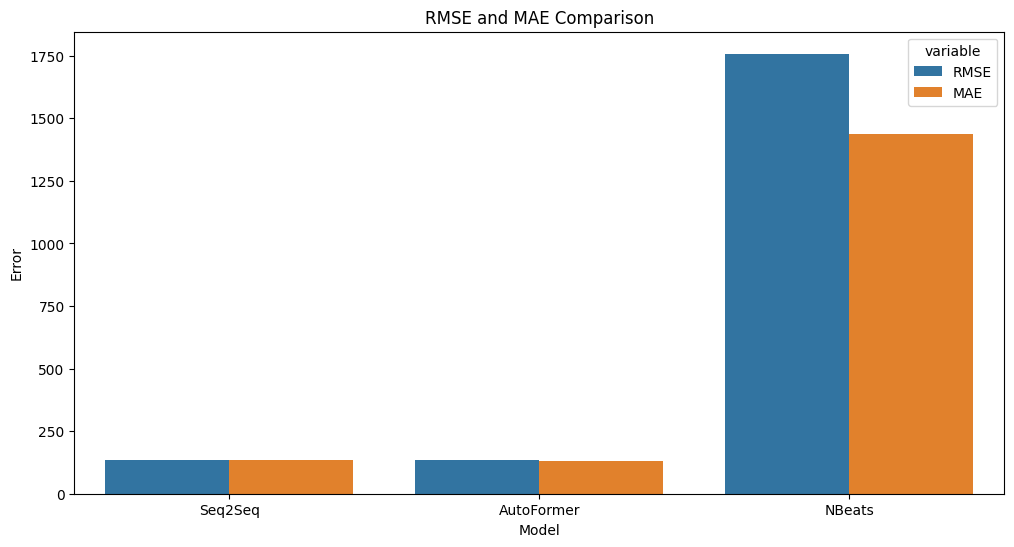

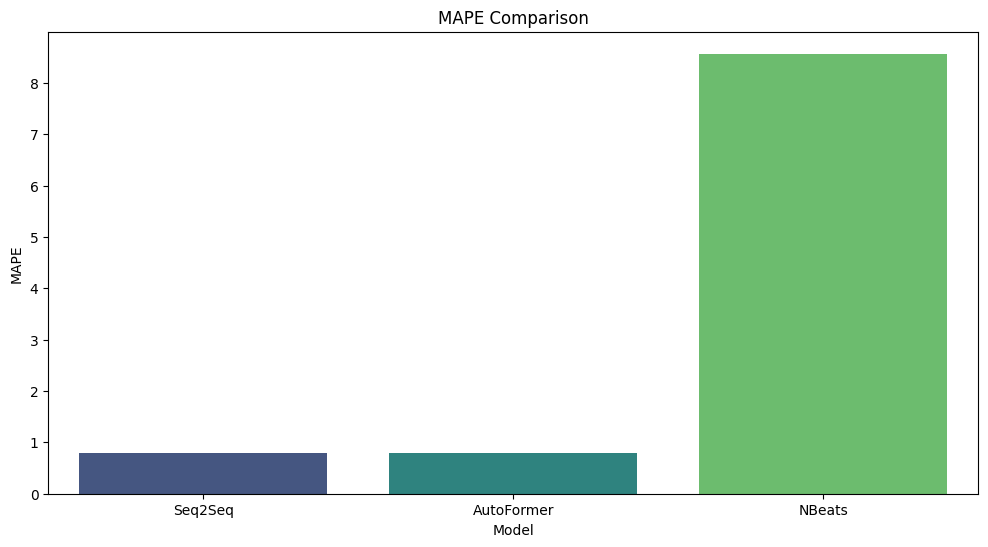

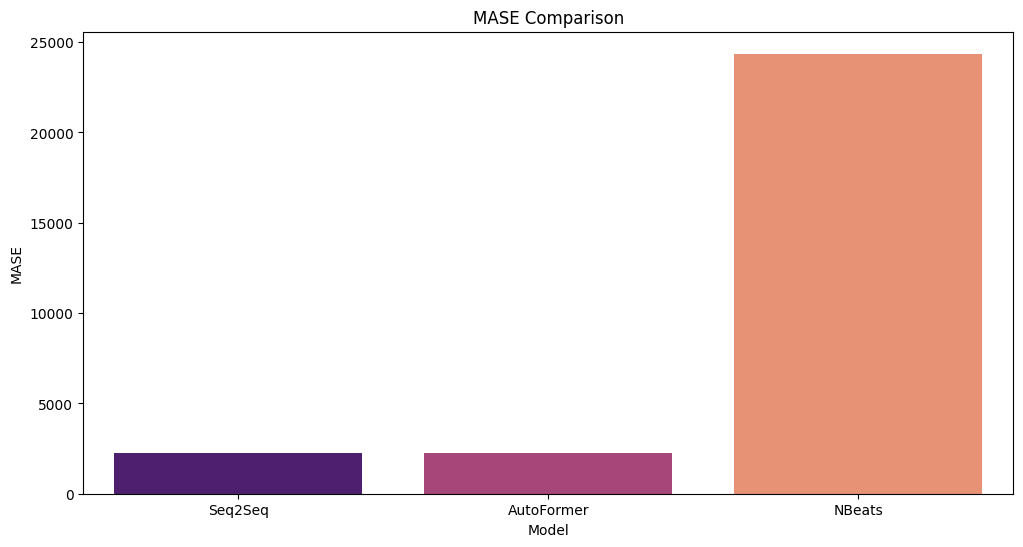

In [48]:
# Execute Metrics Visualization
plot_metrics(metrics_df_tuned)

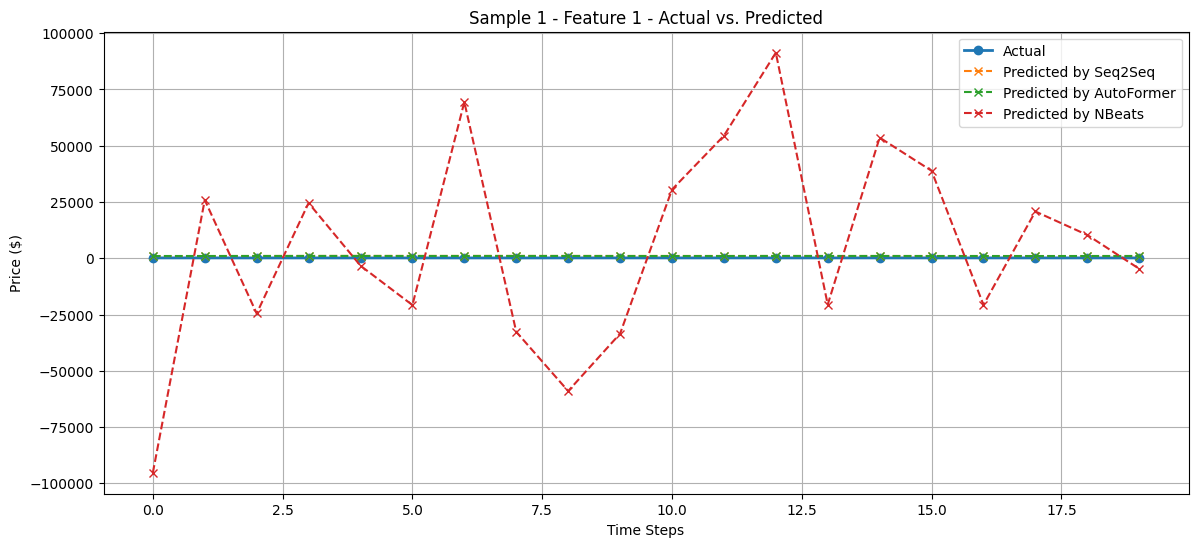

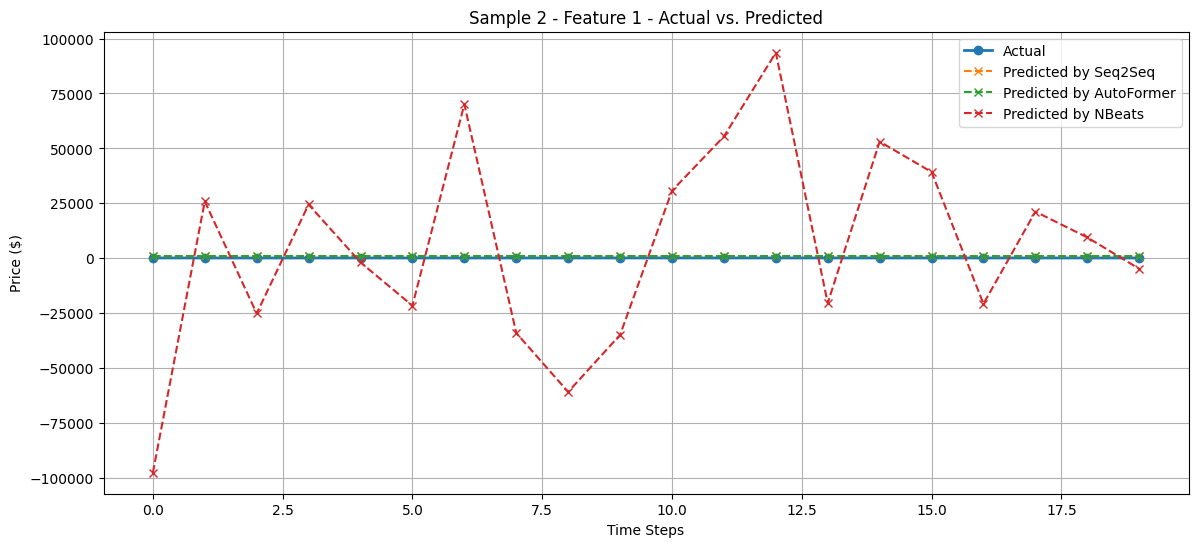

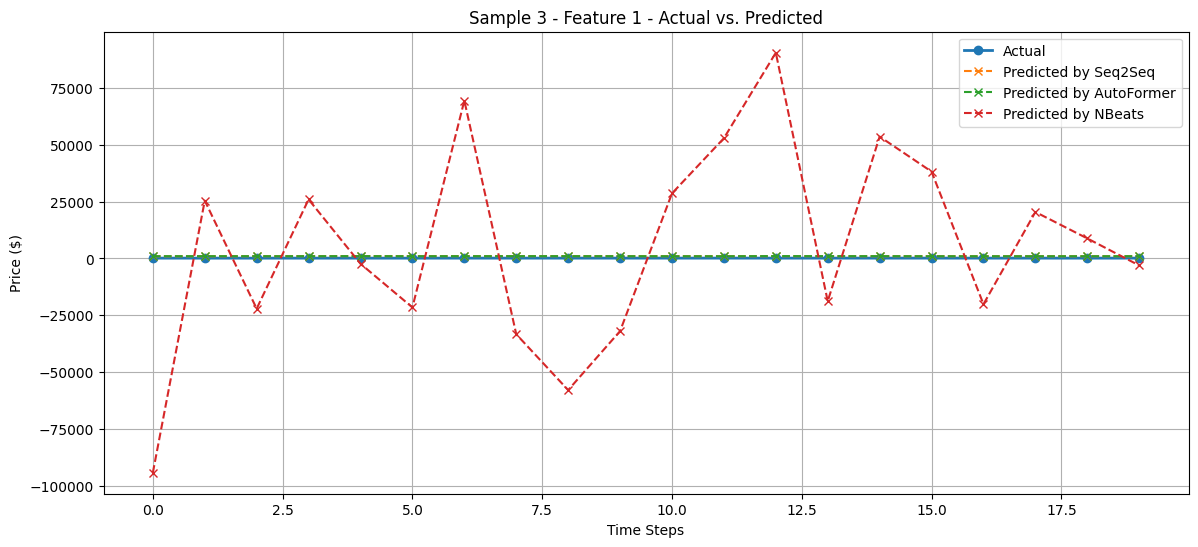

In [49]:
# Define the number of plots and feature index
num_plots = 3
feature_idx = 0

# Define models to exclude
exclude_models = []

# Execute Predictions Visualization
plot_predictions(
    predictions=predictions_tuned,
    y_test=test_labels,
    scaler=scaler,
    mae_naive=mae_naive,
    num_plots=num_plots,
    feature_idx=feature_idx,
    exclude_models=exclude_models
)

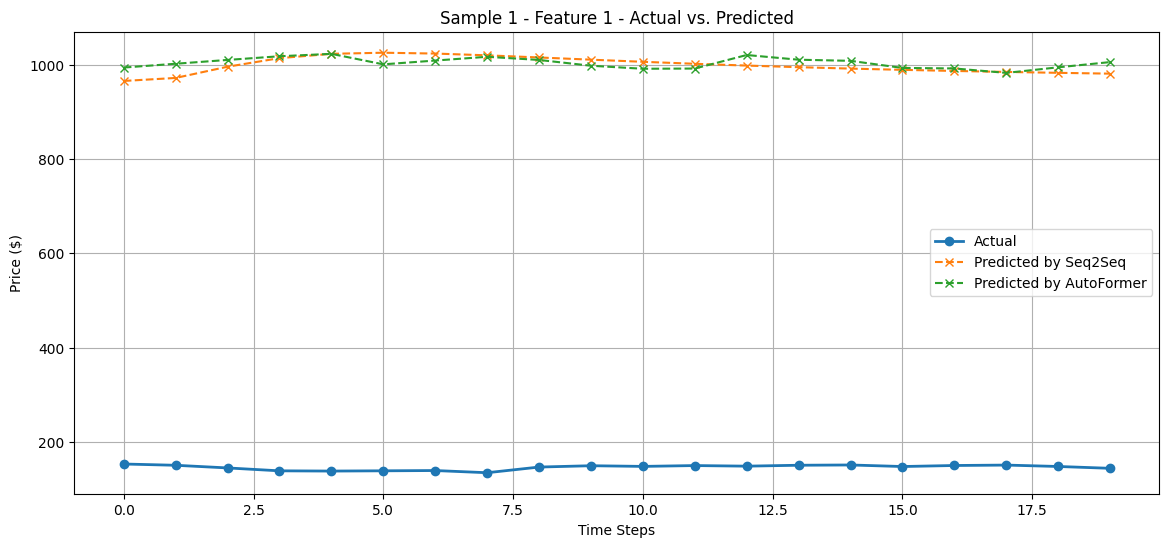

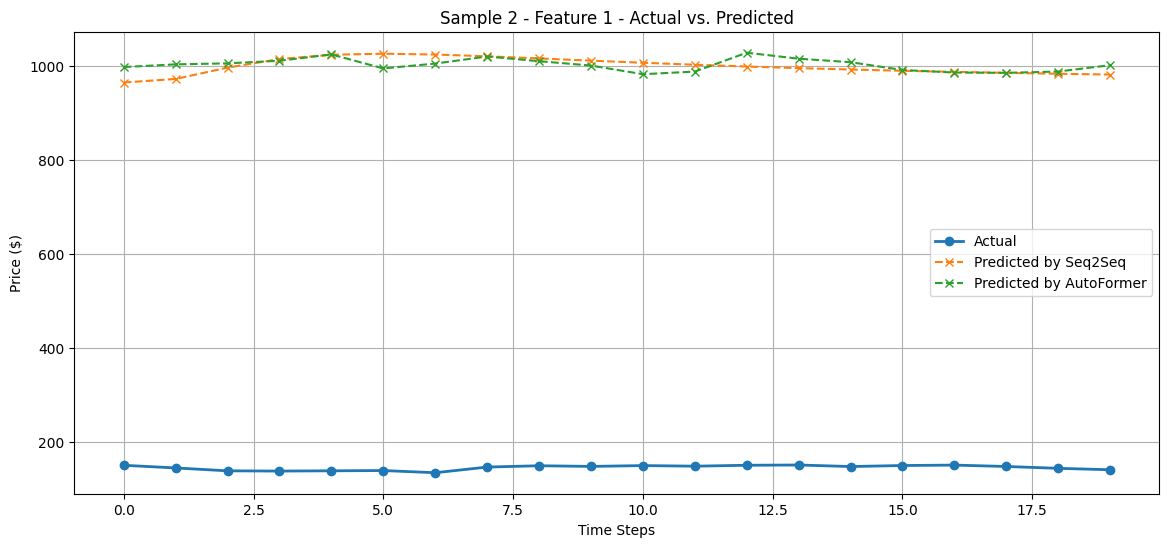

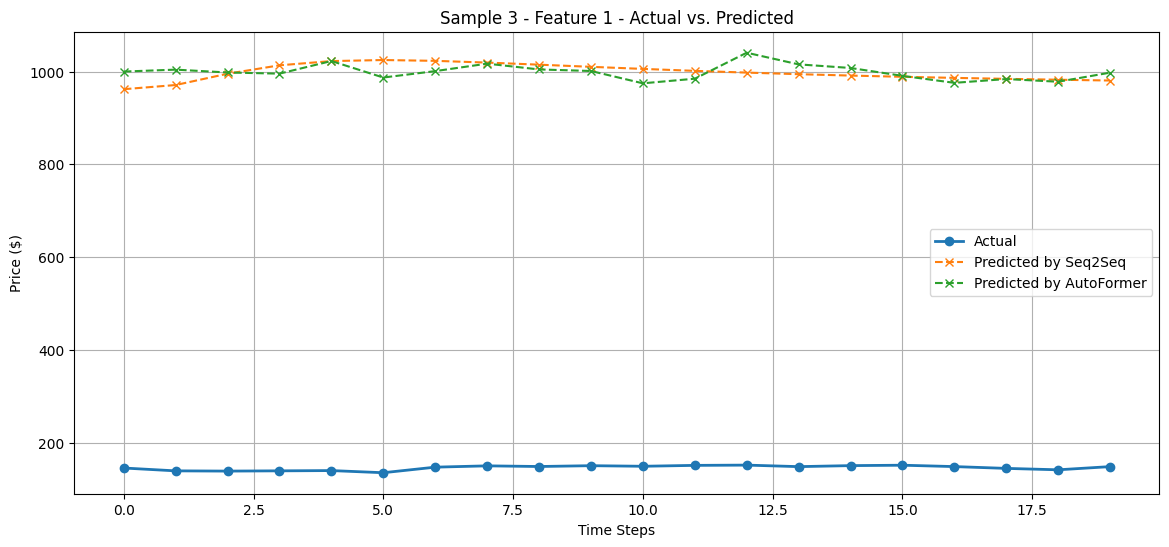

In [50]:
# Define the number of plots and feature index
num_plots = 3
feature_idx = 0

# Define models to exclude
exclude_models = ['NBeats']

# Execute Predictions Visualization
plot_predictions(
    predictions=predictions_tuned,
    y_test=test_labels,
    scaler=scaler,
    mae_naive=mae_naive,
    num_plots=num_plots,
    feature_idx=feature_idx,
    exclude_models=exclude_models
)

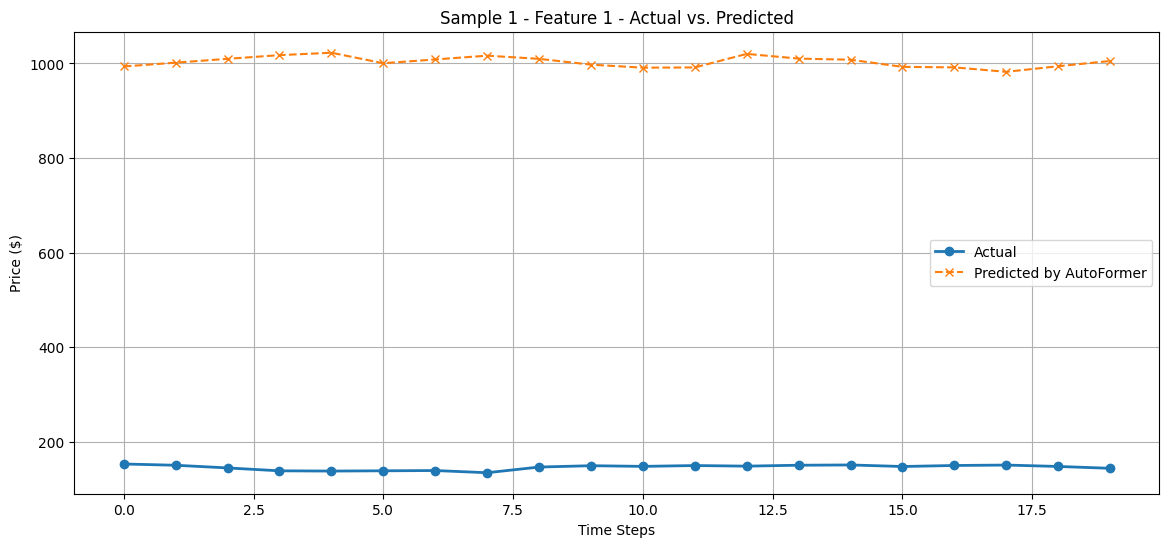

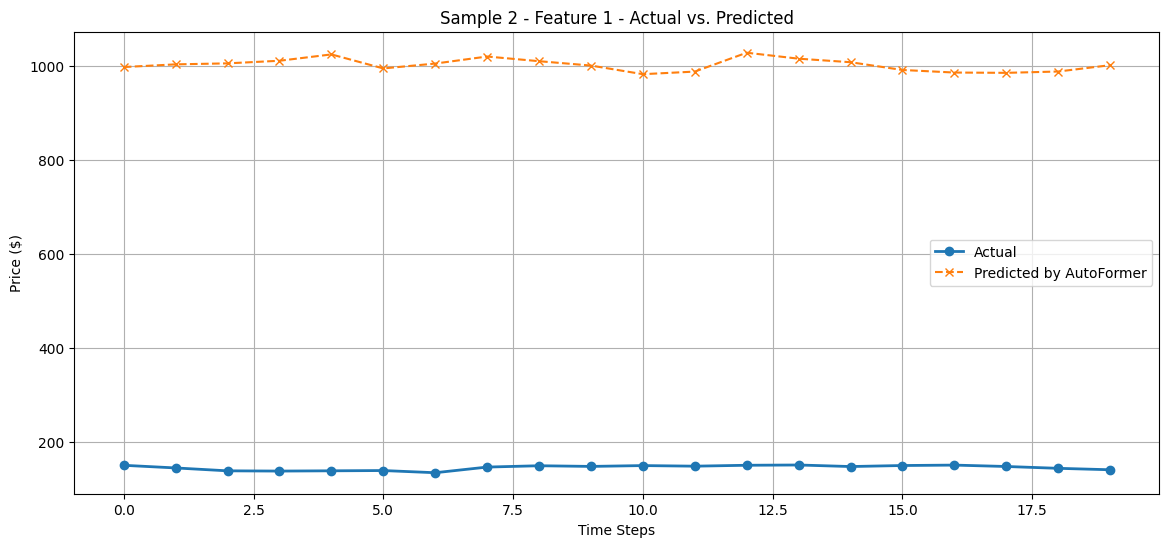

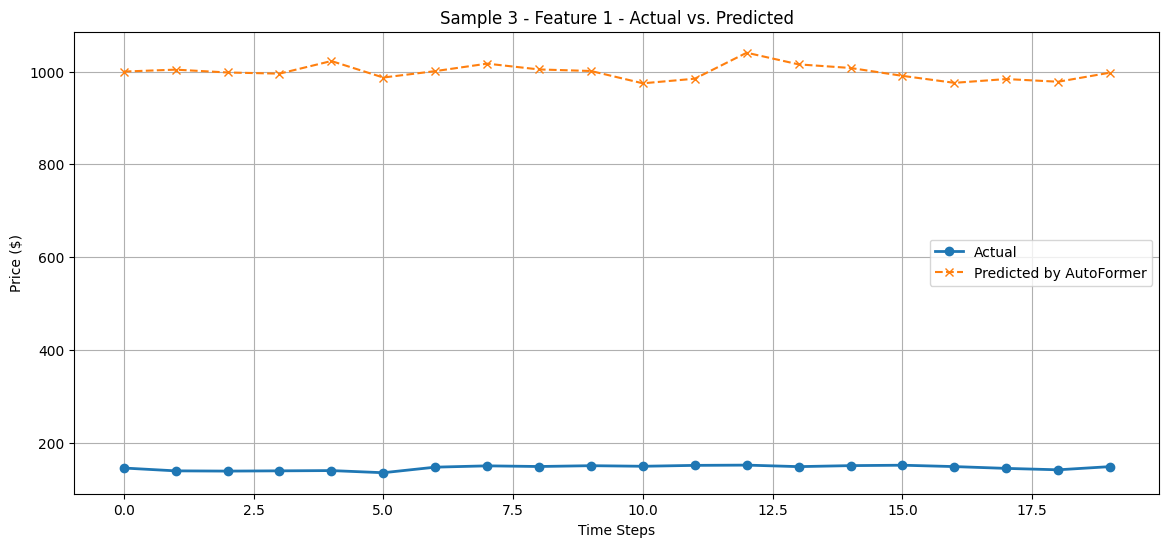

In [51]:
# Define the number of plots and feature index
num_plots = 3
feature_idx = 0

# Define models to exclude
exclude_models = ['NBeats', 'Seq2Seq']

# Execute Predictions Visualization
plot_predictions(
    predictions=predictions_tuned,
    y_test=test_labels,
    scaler=scaler,
    mae_naive=mae_naive,
    num_plots=num_plots,
    feature_idx=feature_idx,
    exclude_models=exclude_models
)